In [1]:
import pysam
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import choice
import os
import csv
import json
from scipy.stats import spearmanr
import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

import holoviews as hv
from holoviews import opts, dim
from bokeh.plotting import show
from holoviews.operation import contours
hv.extension('matplotlib')

# from ipywidgets import IntProgress
# from IPython.display import display

TRANSCRIPT_RATIO = {'SIRV101': 1.0, 'SIRV102': 0.25, 'SIRV103': 1.0, 'SIRV105': 4.0, 'SIRV106': 1.0, 'SIRV107': 4.0, 'SIRV109': 0.03125, 'SIRV201': 0.25, 'SIRV202': 4.0, 'SIRV203': 0.5, 'SIRV204': 1.0, 'SIRV205': 0.03125, 'SIRV206': 0.25, 'SIRV301': 4.0, 'SIRV302': 0.03125, 'SIRV303': 1.0, 'SIRV304': 0.03125, 'SIRV305': 0.25, 'SIRV306': 0.25, 'SIRV307': 1.0, 'SIRV308': 4.0, 'SIRV309': 0.25, 'SIRV310': 0.03125, 'SIRV311': 4.0, 'SIRV403': 0.03125, 'SIRV404': 1.0, 'SIRV405': 0.03125, 'SIRV406': 4.0, 'SIRV408': 0.03125, 'SIRV409': 0.25, 'SIRV410': 4.0, 'SIRV501': 0.25, 'SIRV502': 0.03125, 'SIRV503': 0.25, 'SIRV504': 0.25, 'SIRV505': 1.0, 'SIRV506': 1.0, 'SIRV507': 0.03125, 'SIRV508': 4.0, 'SIRV509': 0.25, 'SIRV510': 0.03125, 'SIRV511': 0.03125, 'SIRV512': 0.25, 'SIRV601': 0.03125, 'SIRV602': 4.0, 'SIRV603': 0.03125, 'SIRV604': 1.0, 'SIRV605': 0.25, 'SIRV606': 0.25, 'SIRV607': 1.0, 'SIRV608': 0.25, 'SIRV609': 1.0, 'SIRV610': 0.25, 'SIRV611': 0.03125, 'SIRV612': 4.0, 'SIRV613': 1.0, 'SIRV614': 0.25, 'SIRV615': 0.25, 'SIRV616': 4.0, 'SIRV617': 1.0, 'SIRV701': 0.25, 'SIRV702': 0.03125, 'SIRV703': 0.03125, 'SIRV704': 0.03125, 'SIRV705': 1.0, 'SIRV706': 1.0, 'SIRV708': 1.0}
# GTF = "SIRV_Set1_Lot00141_Sequences_170612a/SIRVome_isoforms_Lot00141_C_170612a.gtf"

PATH_TO_BAM = "/home/ericcumunel/Documents/Aster/bam/spike_in/"
PATH_TO_PLOT = "/home/ericcumunel/Documents/Aster/plot/coverage_lineplots/"

bam_files = {
    "dRNA_ds3": "BYK_GCA_ONT_1_FAK74085_A.bam",
    "cDNA_ds3": "BYK_GCB_ONT_1_FAK69539_A.bam",
    "dRNA_ds3_new_basecaller": "BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam",
    "cDNA_ds3_new_basecaller": "BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam",
    "dRNA_ds4_new_protocols": "BYK_GDB_ONT_1_PAD67469_A.bam",
    "cDNA_ds4_new_protocols": "BYK_GDC_ONT_1_FAL21661_A.bam",
    "dRNA_ds4_new_basecaller": "BYK_GDB_ONT_1_PAD67469_Aflipflop.bam",
    "cDNA_ds4_new_basecaller": "BYK_GDC_ONT_1_FAL21661_Aflipflop.bam"
}

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

## Minimap2 command generator

In [ ]:
fasta_cDNA_list = []
fasta_dRNA_list = []
for t, bam in bam_files.items():
    fasta_file = bam[:-3] + "fastq.gz"
    if t.startswith("dRNA"):
        fasta_dRNA_list.append(fasta_file)
    elif t.startswith("cDNA"):
        fasta_cDNA_list.append(fasta_file)
    else :
        print(bam, t)

minimap2_exe = "/data/home/ecumunel/softs/minimap2/minimap2"
transcriptome = "/data/home/ecumunel/Aster/fasta/SIRV_transcriptome.fa"
output_path = "/newdisk/ecumunel/Aster/bam/aligned_against_transcriptome/spike_in/remapped/"
read_path = "/newdisk/ecumunel/Aster/raw_data/reads/"
commande_totale = "nohup "
for fasta in fasta_cDNA_list :
    input = read_path + fasta
    output = output_path + fasta[:-8] + "bam"
    command_cDNA = minimap2_exe + " -t 12 -ax map-ont " + transcriptome + " " + input + " > " + output + "\n"
    commande_totale += command_cDNA
for fasta in fasta_dRNA_list :
    input = read_path + fasta
    output = output_path + fasta[:-8] + "bam"
    command_dRNA = minimap2_exe + " -t 12 -ax map-ont " + transcriptome + " " + input + " > " + output + "\n "
    commande_totale += command_dRNA
print(commande_totale[:-2])

## Fonctions de Filtering

In [2]:

def filtering_80QC(bamfile) -> str:
    inputFile = pysam.AlignmentFile(bamfile, "rb")
    outputFile = bamfile[:-3] + "filtered_80QC.bam"
    if os.path.isfile(outputFile):
        logging.info(bamfile + "Has already been filtered.")
        return outputFile
    else :
        filtered_bamfile = pysam.AlignmentFile(outputFile, "wb", template = inputFile)
        for alignment in inputFile:
            if alignment.is_secondary or alignment.is_supplementary or alignment.is_unmapped:
                pass
            else :
                if has_QC_greater_than_80(alignment) :
                    filtered_bamfile.write(alignment)
        inputFile.close()
        filtered_bamfile.close()
        logging.info("Filtering DONE (resulting file = " + outputFile +")")
        return outputFile

def has_QC_greater_than_80(alignment) -> bool:
    read_length = alignment.infer_query_length()
    alignment_length = alignment.query_alignment_length
    ratio_alignment = float(alignment_length + 20) / float(read_length) # We add 20 to compensate polyA tail length, as it can mess with small transcripts 
    return ratio_alignment>=0.80
    
def filtering_80QC_Camille(bamfile) -> str:
    inputFile = pysam.AlignmentFile(bamfile, "rb")
    outputFile = bamfile[:-3] + "filtered_80QC_old.bam"
    if os.path.isfile(outputFile):
        logging.info(bamfile + " has already been filtered.")
        return outputFile
    else :
        filtered_bamfile = pysam.AlignmentFile(outputFile, "wb", template = inputFile)
        for read in inputFile:
            if read.is_secondary or read.is_supplementary or read.is_unmapped:
                pass
            else :
                if has_QC_greater_than_80_old(read) :
                    filtered_bamfile.write(read)
        inputFile.close()
        filtered_bamfile.close()
        logging.info("Filtering DONE (resulting file = " + outputFile +")")
        return outputFile

def has_QC_greater_than_80_old(alignment) -> bool:
    read_length = alignment.infer_query_length()
    alignment_length = alignment.query_alignment_length
    ratio_alignment = float(alignment_length) / float(read_length) 
    return ratio_alignment>=0.80

def filtering_80QC_unmapped_and_supplementary(bamfile) :
    inputFile = pysam.AlignmentFile(bamfile, "rb")
    outputFile = bamfile[:-3] + "filtered_80QC.keep_secondary.bam"
    filtered_bam = pysam.AlignmentFile(outputFile, "wb", template = inputFile)
    for ali in inputFile:
        if ali.is_supplementary or ali.is_unmapped:
            pass
        else :
            if has_QC_greater_than_80(ali):
                filtered_bam.write(ali)
    return outputFile
                
def sort_by_read_name(bamfile):
    outputFile = bamfile[:-3] + "sorted_by_read_names.bam"
    pysam.sort("-n", bamfile, "-o", outputFile)
    return outputFile            

def filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(bamfile) -> str:
    temp_file = filtering_80QC_unmapped_and_supplementary(bamfile)    
    return sort_by_read_name(temp_file)
    

# def filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(bamfile) -> str:
#     inputFile = pysam.AlignmentFile(bamfile, "rb")
#     outputFile1 = bamfile[:-3] + "filtered.bam"
#     outputFile2 = bamfile[:-3] + "filtered_80QC.keep_secondary.sorted_by_read_names.bam"

# #     outputFile2 = bamfile[:-3] + "filtered_and_sorted_by_read_names.bam"
#     if os.path.isfile(outputFile2):
#         logging.info(bamfile + " has already been treated.")
#         return outputFile2
#     else :
#         logging.info("Filtering " + bamfile + "...")
#         treated_bamfile = pysam.AlignmentFile(outputFile1, "wb", template = inputFile)
#         for alignment in inputFile:
#             if alignment.is_supplementary or alignment.is_unmapped:
#                 pass
#             else :
#                 if has_QC_greater_than_80(alignment) :
#                     treated_bamfile.write(alignment)
#         logging.info("Sorting " + bamfile + "...")
# #         pysam.sort("-n", outputFile1, "-o", outputFile2)  # This command doesn't seem to work as expected...
#         os.system("samtools sort -n " + outputFile1 + " -o " + outputFile2)
#         os.remove(outputFile1)
#         logging.info("Sorting done.")
#         inputFile.close()
#         treated_bamfile.close()
#         return outputFile2

## Réattribution des primaires en fonction de la distance en 3' sans heuristique

In [3]:
def reattribute_primary_reads_using_3end_dist_no_heu(bamfile, transcript_ratio, output = False):
    # bamfile needs to be filtered and sorted by read names first. Checking if this is already the case :
    treated_bamfile = filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(bamfile)
    inputFile = pysam.AlignmentFile(treated_bamfile, 'rb')
    switch_dict = dict() # Keeping in memory what modifications are being made with the script
    new_bamfile = bamfile[:-3] + "filtered.new_primary.no_heuristic.bam"
    if os.path.isfile(new_bamfile):
        pass
#         return get_countings_from_treated_bam(new_bamfile, transcript_ratio)
    if output :
        new_bam = pysam.AlignmentFile(new_bamfile, 'wb', template = inputFile)
    read_name = None
    alignments_cluster = [] #List of all alignments corresponding to one read


    for alignment in inputFile :
        if alignment.query_name == read_name :
            alignments_cluster.append(alignment)
        else :
            if alignments_cluster != []:
                new_primary_alignment = choose_new_primary_using_3end_dist_no_heu(alignments_cluster, inputFile)
                update_switch(switch_dict, alignments_cluster, new_primary_alignment)
                if output:
                    set_flag_to_primary(new_primary_alignment)
                    new_bam.write(new_primary_alignment)
            alignments_cluster = [alignment]
            read_name = alignment.query_name
    if alignments_cluster != []:
        new_primary_alignment = choose_new_primary_using_3end_dist_no_heu(alignments_cluster, inputFile)
        update_switch(switch_dict, alignments_cluster, new_primary_alignment)
        if output:
            set_flag_to_primary(new_primary_alignment)
            new_bam.write(new_primary_alignment)
            new_bam.close()
    return [new_bamfile, switch_dict]


def choose_new_primary_using_3end_dist_no_heu(alignments, inputFile):
    alignments_with_best_AS = get_alignments_with_max_AS(alignments)
    alignments_with_best_3end_dist = get_alignments_with_best_3end_dist_no_heu(alignments_with_best_AS, inputFile)
    return choice(alignments_with_best_3end_dist)



def get_alignments_with_best_3end_dist_no_heu(alignments, inputFile):
    dist_from_3end_dict = dict()
    for ali in alignments:
        dist_from_3end_dict[ali] = get_3end_dist(ali, inputFile)
    min_dist = min(dist_from_3end_dict.values())
    best_alignments = [ali for ali, dist in dist_from_3end_dict.items() if dist == min_dist]
    return list(set(best_alignments))

def get_alignments_with_max_AS(alignments):
    best_AS = max([ali.get_tag("AS") for ali in alignments])
    best_alignments = [ali for ali in alignments if ali.get_tag("AS") == best_AS]

    return best_alignments

def get_3end_dist(alignment, inputFile):
    transcript_ID = alignment.reference_name
    transcript_length = inputFile.get_reference_length(transcript_ID)
    dist_from_3end = transcript_length - alignment.reference_end
    return dist_from_3end

def get_primary_alignment(alignments):
    for alignment in alignments :
        if not alignment.is_secondary :
            return alignment
    raise ValueError("No primary alignment detected for " + alignment.query_name)

def update_switch(switch_dict, alignments_cluster, new_primary_alignment):
    try :
        previous_primary_alignment = get_primary_alignment(alignments_cluster)
        source = previous_primary_alignment.reference_name
    except ValueError:
        source = "Primary_filtered!"
#         target = new_primary_alignment.reference_name
#         switch_dict[new_primary_alignment.query_name] = [None, new_primary_alignment.reference_name]
#         return switch_dict
#     switch_dict[new_primary_alignment.query_name] = [previous_primary_alignment.reference_name, new_primary_alignment.reference_name]
#     print(source)
    target = new_primary_alignment.reference_name
    switch = source + " " + target
    if switch not in switch_dict.keys():
        switch_dict[switch] = 1
    else :
        switch_dict[switch] += 1
        
    return switch_dict

def set_flag_to_primary(alignment):
    alignment.flag = int(bin(alignment.flag & 3839),2)

def get_countings_from_bamfile(bamfile, transcript_ratio):
    ## Warning : only works with bam containing only primary reads
    logging.info("Recovering countings from " + bamfile + "...")
    countings_dict = {transcript:0 for transcript in transcript_ratio.keys()}
    read_name = None
    read_alignments = []
    inputFile = pysam.AlignmentFile(bamfile, 'rb')
    for alignment in inputFile :
        if alignment.reference_name not in countings_dict.keys():
            countings_dict[alignment.reference_name] = 1
        else :
            countings_dict[alignment.reference_name] +=1
    logging.info("Countings done for " + bamfile)
    return countings_dict

def save_dict_to_json(dic, filename) :
    with open(filename, 'w') as f:
        json.dump(dic, f)
    return filename
    
def load_dict_from_json(filename):
    with open(filename, 'r') as f:
        dic = json.loads(f.readline())
    return dic

## Réattribution des primaires en fonction de la distance en 3' avec heuristique 1

In [4]:
def reattribute_primary_reads_using_3end_dist_heu_1(bamfile, transcript_ratio, output = False):
    # bamfile needs to be filtered and sorted by read names first. Checking if this is already the case :
    treated_bamfile = filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(bamfile)
    inputFile = pysam.AlignmentFile(treated_bamfile, 'rb')
    switch_dict = dict() # Keeping in memory what modifications are being made with the script
    new_bamfile = bamfile[:-3] + "filtered.new_primary.heu_1.bam"
    if os.path.isfile(new_bamfile):
        pass
#         return get_countings_from_treated_bam(new_bamfile, transcript_ratio)
    if output :
        new_bam = pysam.AlignmentFile(new_bamfile, 'wb', template = inputFile)
    read_name = None
    alignments_cluster = [] #List of all alignments corresponding to one read


    for alignment in inputFile :
        if alignment.query_name == read_name :
            alignments_cluster.append(alignment)
        else :
            if alignments_cluster != []:
                new_primary_alignment = choose_new_primary_using_3end_dist_heu_1(alignments_cluster, inputFile)
                update_switch(switch_dict, alignments_cluster, new_primary_alignment)
                if output:
                    set_flag_to_primary(new_primary_alignment)
                    new_bam.write(new_primary_alignment)
            alignments_cluster = [alignment]
            read_name = alignment.query_name
    if alignments_cluster != []:
        new_primary_alignment = choose_new_primary_using_3end_dist_heu_1(alignments_cluster, inputFile)
        update_switch(switch_dict, alignments_cluster, new_primary_alignment)
        if output:
            set_flag_to_primary(new_primary_alignment)
            new_bam.write(new_primary_alignment)
    return [new_bamfile, switch_dict]


def choose_new_primary_using_3end_dist_heu_1(alignments, inputFile):
    alignments_with_best_AS = get_alignments_with_max_AS(alignments)
    alignments_with_best_3end_dist = get_alignments_with_best_3end_dist_heu_1(alignments_with_best_AS, inputFile)
    return choice(alignments_with_best_3end_dist)



def get_alignments_with_best_3end_dist_heu_1(alignments, inputFile):
    dist_from_3end_dict = dict()
    for ali in alignments:
        dist_from_3end_dict[ali] = get_3end_dist(ali, inputFile)
    min_dist = min(dist_from_3end_dict.values())
    if min_dist > 100 :
        return list(set(alignments))
    best_alignments = [ali for ali, dist in dist_from_3end_dict.items() if dist == min_dist]
    return list(set(best_alignments))

## Réattribution des primaires en fonction de la distance en 3' avec heuristique 1 et 2

In [5]:
def reattribute_primary_reads_using_3end_dist_heu_2(bamfile, transcript_ratio, output = False):
    # bamfile needs to be filtered and sorted by read names first. Checking if this is already the case :
    treated_bamfile = filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(bamfile)
    inputFile = pysam.AlignmentFile(treated_bamfile, 'rb')
    switch_dict = dict() # Keeping in memory what modifications are being made with the script
    new_bamfile = bamfile[:-3] + "filtered.new_primary.heu_2.bam"
    if os.path.isfile(new_bamfile):
        pass
#         return get_countings_from_treated_bam(new_bamfile, transcript_ratio)
    if output :
        new_bam = pysam.AlignmentFile(new_bamfile, 'wb', template = inputFile)
    read_name = None
    alignments_cluster = [] #List of all alignments corresponding to one read


    for alignment in inputFile :
        if alignment.query_name == read_name :
            alignments_cluster.append(alignment)
        else :
            if alignments_cluster != []:
                new_primary_alignment = choose_new_primary_using_3end_dist_heu_2(alignments_cluster, inputFile)
                update_switch(switch_dict, alignments_cluster, new_primary_alignment)
                if output:
                    set_flag_to_primary(new_primary_alignment)
                    new_bam.write(new_primary_alignment)
            alignments_cluster = [alignment]
            read_name = alignment.query_name
    if alignments_cluster != []:
        new_primary_alignment = choose_new_primary_using_3end_dist_heu_2(alignments_cluster, inputFile)
        update_switch(switch_dict, alignments_cluster, new_primary_alignment)
        if output:
            set_flag_to_primary(new_primary_alignment)
            new_bam.write(new_primary_alignment)
    return [new_bamfile, switch_dict]


def choose_new_primary_using_3end_dist_heu_2(alignments, inputFile):
    alignments_with_best_AS = get_alignments_with_max_AS(alignments)
    alignments_with_best_3end_dist = get_alignments_with_best_3end_dist_heu_1(alignments_with_best_AS, inputFile)
    return choice(alignments_with_best_3end_dist)



def get_alignments_with_best_3end_dist_heu_2(alignments, inputFile):
    dist_from_3end_dict = dict()
    for ali in alignments:
        dist_from_3end_dict[ali] = get_3end_dist(ali, inputFile)
    min_dist = min(dist_from_3end_dict.values())
    if min_dist > 100 :
        return list(set(alignments))
    best_alignments = [ali for ali, dist in dist_from_3end_dict.items() if dist == min_dist]
    if min_dist == 0 :
        return best_alignments
    alignments_with_dist_under_threshold = [alignment for alignment, dist in alignments_dist.items() if dist < 100 and alignment not in best_alignments]
    best_transcripts = [alignment.reference_name for alignment in best_alignments]
    best_candidates = best_alignments
    for alignment in alignments_with_dist_under_threshold :
        for transcript in best_transcripts :
            if abs(transcript_end_dict[alignment.reference_name] - transcript_end_dict[transcript]) < 10 :
                best_candidates.append(alignment)
    return list(set(best_candidates))

## Génération des nouveaux bams

In [7]:
complete_switch_dict = dict()
complete_counts_dict = dict()

bam_files = {
    "dRNA_ds3": "BYK_GCA_ONT_1_FAK74085_A.bam",
    "cDNA_ds3": "BYK_GCB_ONT_1_FAK69539_A.bam",
    "dRNA_ds3_new_basecaller": "BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam",
    "cDNA_ds3_new_basecaller": "BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam",
    "dRNA_ds4_new_protocols": "BYK_GDB_ONT_1_PAD67469_A.bam",
    "cDNA_ds4_new_protocols": "BYK_GDC_ONT_1_FAL21661_A.bam",
    "dRNA_ds4_new_basecaller": "BYK_GDB_ONT_1_PAD67469_Aflipflop.bam",
    "cDNA_ds4_new_basecaller": "BYK_GDC_ONT_1_FAL21661_Aflipflop.bam"
}

# bam_files = {
#     "dRNA_ds3": "BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam"}

for bam_name in bam_files.values():
    print("treating " + bam_name)
    bam = PATH_TO_BAM + bam_name
    bam_switch_dict = dict()
    bam_countings = dict()

    bam_countings["filter_1"] = get_countings_from_bamfile(filtering_80QC_Camille(bam), TRANSCRIPT_RATIO)
    bam_countings["filter_2"] = get_countings_from_bamfile(filtering_80QC(bam), TRANSCRIPT_RATIO)
    print("Filtered only DONE")

    newbam_no_heu, switch_dict = reattribute_primary_reads_using_3end_dist_no_heu(bam, TRANSCRIPT_RATIO, output=True)
    bam_switch_dict["no_heu"] = switch_dict

    bam_countings["no_heu"] = get_countings_from_bamfile(newbam_no_heu, TRANSCRIPT_RATIO)
    
    print("no heu DONE")
    
    newbam_heu_1, switch_dict = reattribute_primary_reads_using_3end_dist_heu_1(bam, TRANSCRIPT_RATIO, output=True)
    bam_switch_dict["heu_1"] = switch_dict
    bam_countings["heu_1"] = get_countings_from_bamfile(newbam_heu_1, TRANSCRIPT_RATIO)

    print("Heu1 Done")
    
    newbam_heu_2, switch_dict = reattribute_primary_reads_using_3end_dist_heu_2(bam, TRANSCRIPT_RATIO, output=True)
    bam_switch_dict["heu_2"] = switch_dict
    bam_countings["heu_2"] = get_countings_from_bamfile(newbam_heu_2, TRANSCRIPT_RATIO)
    
    print("Heu2 Done")
    
#     print(get_quantif_correlation_from_countings(bam_countings["filter_1"], TRANSCRIPT_RATIO))
#     print(get_quantif_correlation_from_countings(bam_countings["filter_2"], TRANSCRIPT_RATIO))
#     print(get_quantif_correlation_from_countings(bam_countings["no_heu"], TRANSCRIPT_RATIO))
#     print(get_quantif_correlation_from_countings(bam_countings["heu_1"], TRANSCRIPT_RATIO))
#     print(get_quantif_correlation_from_countings(bam_countings["heu_2"], TRANSCRIPT_RATIO))

    
    complete_counts_dict[bam_name] = bam_countings
    complete_switch_dict[bam_name] = bam_switch_dict
    

save_dict_to_json(complete_switch_dict, "complete_switch_dict.json")
save_dict_to_json(complete_counts_dict, "complete_counts_dict.json")


INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered_80QC_old.bam...


treating BYK_GCA_ONT_1_FAK74085_A.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCA_ONT_1_FAK74085_A.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered_80QC_old.bam...


Heu2 Done
treating BYK_GCB_ONT_1_FAK69539_A.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered_80QC_old.bam...


Heu2 Done
treating BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered_80QC_old.bam...


Heu2 Done
treating BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GCB_ONT_1_FAK69539_A.basecallHA.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered_80QC_old.bam...


Heu2 Done
treating BYK_GDB_ONT_1_PAD67469_A.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_A.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered_80QC_old.bam...


Heu2 Done
treating BYK_GDC_ONT_1_FAL21661_A.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_A.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC_old.bam...


Heu2 Done
treating BYK_GDB_ONT_1_PAD67469_Aflipflop.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered.new_primary.heu_2.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.bam has already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered_80QC_old.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered_80QC_old.bam
INFO:root:/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.bamHas already been filtered.
INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered_80QC.bam...


Heu2 Done
treating BYK_GDC_ONT_1_FAL21661_Aflipflop.bam


INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered_80QC.bam


Filtered only DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.no_heuristic.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.no_heuristic.bam


no heu DONE


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.heu_1.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.heu_1.bam


Heu1 Done


INFO:root:Recovering countings from /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.heu_2.bam...
INFO:root:Countings done for /home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.heu_2.bam


Heu2 Done


'complete_counts_dict.json'

# Quantifications et calcul de corrélation

In [16]:
complete_counts_dict = load_dict_from_json("complete_counts_dict.json");
complete_switch_dict = load_dict_from_json("complete_switch_dict.json");

In [17]:
def get_quantif_correlation_from_file(bamfile, transcript_ratio):
    bamfile = pysam.AlignmentFile(bamfile, "r")
    transcript_found_counting = dict()
    for alignment in bamfile:
        if alignment.reference_name not in transcript_found_counting :
            transcript_found_counting[alignment.reference_name] = 1
        else :
            transcript_found_counting[alignment.reference_name] +=1
    countings = []
    real_quantif = []

    with open("bam/spike_in/new_counting.tsv", 'w') as f:
        for transcript in transcript_ratio.keys():
            if transcript in transcript_found_counting.keys() :
                countings.append(transcript_found_counting[transcript])
                real_quantif.append(transcript_ratio[transcript])
            else :
                countings.append(0)
                real_quantif.append(transcript_ratio[transcript])
#     logging.info("Counting done, computing Spearman correlation...")
    return spearmanr(countings, real_quantif)

def get_quantif_correlation_from_countings(transcript_found_counting, transcript_ratio):
#     logging.info("Counting in progress...")
    countings = []
    real_quantif = []
    for transcript in transcript_ratio.keys():
        real_quantif.append(transcript_ratio[transcript])
        if transcript in transcript_found_counting.keys(): # TODO : need a fix
            countings.append(transcript_found_counting[transcript])
        else :
            countings.append(0)
#     logging.info("Counting done, computing Spearman correlation...")
    return spearmanr(countings, real_quantif)

def get_ratio_of_reattributed_read(switch_dict):
    total_nb_of_read = sum(switch_dict.values())
    nb_of_switched_read = 0
    for transcript_switch, counts in switch_dict.items():
        t1, t2 = transcript_switch.split()
        if t1 != t2:
            nb_of_switched_read += counts
    return nb_of_switched_read/total_nb_of_read


In [18]:
datasets = [ds for ds in bam_files.keys()]
methods = list(complete_counts_dict[list(bam_files.values())[0]].keys())
data = dict()
data['Dataset'] = datasets
cor_by_method = {}
ratio_of_reattributed_by_method = {}
for bam_name in bam_files.values():
    for method in complete_counts_dict[bam_name].keys():
        colname = method + " Corr"
        cor = list(get_quantif_correlation_from_countings(complete_counts_dict[bam_name][method], TRANSCRIPT_RATIO))[0]
        if colname in cor_by_method.keys():
            cor_by_method[colname].append(cor)
        else :
            cor_by_method[colname] = [cor]
for bam_name, switch_dict in complete_switch_dict.items():
    for method in switch_dict.keys():
        colname = method + " ratio"
        ratio = get_ratio_of_reattributed_read(complete_switch_dict[bam_name][method])

        if colname in ratio_of_reattributed_by_method.keys():
            ratio_of_reattributed_by_method[colname].append(ratio)
        else :
            ratio_of_reattributed_by_method[colname] = [ratio]
            
for method in cor_by_method.keys():
    data[method] = cor_by_method[method]
for method in ratio_of_reattributed_by_method.keys():
    data[method] = ratio_of_reattributed_by_method[method]

df = pd.DataFrame(data)
# df.to_csv("data.csv", index=False)


df

Dataset  filter_1 Corr  filter_2 Corr  heu_1 Corr  \
0                 dRNA_ds3       0.834720       0.837802    0.889164   
1                 cDNA_ds3       0.648228       0.680377    0.735008   
2  dRNA_ds3_new_basecaller       0.873919       0.873810    0.945389   
3  cDNA_ds3_new_basecaller       0.649650       0.670260    0.689421   
4   dRNA_ds4_new_protocols       0.862306       0.869360    0.939157   
5   cDNA_ds4_new_protocols       0.734055       0.744346    0.766293   
6  dRNA_ds4_new_basecaller       0.876753       0.880271    0.943900   
7  cDNA_ds4_new_basecaller       0.731916       0.742028    0.779334   

   heu_1 ratio  heu_2 Corr  heu_2 ratio  no_heu Corr  no_heu ratio  
0     0.071639    0.891427     0.072306     0.889576      0.072791  
1     0.027077    0.735011     0.026946     0.727599      0.027234  
2     0.074874    0.944654     0.075014     0.947061      0.075389  
3     0.016935    0.690579     0.016820     0.674660      0.016826  
4     0.073300    0.940518     0.073418     0.939157      0.073200  
5     0.050986    0.762621     0.050110     0.748631      0.048356  
6     0.076555    0.944508     0.076673     0.943137      0.076685  
7     0.049857    0.786119     0.048714     0.775690      0.050286

## Barplot des quantifs selon méthodes

In [19]:
# def multi_plot_quantif(countings, bamfile, transcript_ratio, chrom):
#     sub_ratio = [ratio for transcript, ratio in transcript_ratio.items() if transcript.startswith(chrom)]
#     data = {
#         'Transcript': [transcript for transcript in transcript_ratio.keys() if transcript.startswith(chrom)],
#     }
#     df = pd.DataFrame(data)
#     total_ratio = sum(sub_ratio)
#     for method, counts in countings[bamfile].items():
#         sub_counts = {}
#         total_nb_of_reads = 0
#         counts_ratio = []
#         for transcript in df["Transcript"]:
#             sub_counts[transcript] = counts[transcript]
#             total_nb_of_reads += counts[transcript]
#         expected_reads_dict = {}
#         for transcript in df["Transcript"]:
#             expected_reads_dict[transcript] = total_nb_of_reads / total_ratio * transcript_ratio[transcript]
#             ratio= (sub_counts[transcript] + 1) / (expected_reads_dict[transcript] + 1)
#             counts_ratio.append(math.log10(ratio))
#         df[method] = counts_ratio

#     cols = df.columns.tolist()
#     if cols == ['Transcript', 'heu_2', 'no_heu', 'filter_2', 'filter_1', 'heu_1']:
#         df = df[['Transcript','filter_1','filter_2','no_heu','heu_1','heu_2']]
#     df = pd.melt(df, id_vars="Transcript", var_name="method", value_name="diff_ratio")
#     sns.set(color_codes=True, style="whitegrid");
#     plt.figure(figsize=(16, len(sub_ratio)))
#     # Uncomment next line to set limits on x axes
#     # plt.xlim(-3, 3)
#     picture_name = "new_plot/" + bamfile[:-3] + chrom +".png"
#     ax = sns.barplot(y="Transcript", x="diff_ratio", hue="method", data=df).set_title(chrom).figure.savefig(picture_name)
#     return df


def show_values_on_bars(ax, diffs, h_v="v", space=0.1):
    if h_v == "v":
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = int(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    elif h_v == "h":
        for i, p in enumerate(ax.patches):
            if p.get_width() < 0:
#                 _x = p.get_width() - 0.03 * ( len(str(int(diffs[i]))) + 1) - float(space)
                _x = p.get_width() - 0.035 * ( len(str(diffs[i])) + 1) - float(space)
            else :
                _x = p.get_x() + p.get_width() + float(space)
# #             if p.get_width() < 0:
# #                 _x = p.get_x() - p.get_width() - float(space)
# #             else :
#             _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()/2 + 0.05
            value = diffs[i]
#             if value < 0 :
#                 value = "(" + str(int(value)) + ")"
#             else :
#                 value = "(+" + str(int(value)) + ")"
            ax.text(_x, _y, value, ha="left", color = "grey")


def multi_plot_quantif(countings, bamfile, transcript_ratio, chrom, methods = None, methods_names = None):
    sub_ratio = [ratio for transcript, ratio in transcript_ratio.items() if transcript.startswith(chrom)]
    data = {
        'Transcript': [transcript for transcript in transcript_ratio.keys() if transcript.startswith(chrom)],
    }
    df = pd.DataFrame(data)
    total_ratio = sum(sub_ratio)
    diffs = []
    if methods == None :
        methods = list(countings[bamfile].keys())

    for method in methods :
        counts = countings[bamfile][method]
        sub_counts = {}
        total_nb_of_reads = 0
        counts_ratio = []
        for transcript in df["Transcript"]:
            sub_counts[transcript] = counts[transcript]
            total_nb_of_reads += counts[transcript]
        expected_reads_dict = {}
        for transcript in df["Transcript"]:
            expected_reads_dict[transcript] = round(total_nb_of_reads / total_ratio * transcript_ratio[transcript])
            if sub_counts[transcript] == 0 and expected_reads_dict[transcript] != 0:
                ratio = (sub_counts[transcript] + 1) / (expected_reads_dict[transcript] + 1)
            elif sub_counts[transcript] != 0 and expected_reads_dict[transcript] == 0:
                ratio = (sub_counts[transcript] + 1) / (expected_reads_dict[transcript] + 1)
            else :
                ratio = sub_counts[transcript] / expected_reads_dict[transcript]
            diffs.append(str(sub_counts[transcript]) + ' / ' + str(int(expected_reads_dict[transcript])))
#             diffs.append("ahah")
            counts_ratio.append(math.log10(ratio))
        df[method] = counts_ratio
    methods_names = methods if methods_names == None else methods_names
    df.rename(columns=dict(zip(methods, methods_names)), 
                 inplace=True)
    
    df = pd.melt(df, id_vars="Transcript", var_name="method", value_name="log_ratio  du nombre observé de reads / nombre attendu de reads")
    sns.set(color_codes=True, style="whitegrid");
    plt.figure(figsize=(16, len(sub_ratio)*1.6))
    picture_name = "plot/" + bamfile[:-3] + chrom +".png"
    plt.xlim(-2.8, 2.8)
    ax = sns.barplot(y="Transcript", x="log_ratio  du nombre observé de reads / nombre attendu de reads", hue="method", data=df)
    ax.xaxis.set_major_locator(plt.LinearLocator(15))
    show_values_on_bars(ax, diffs, "h", space =0.03)
    ax = ax.set_title(chrom).figure.savefig(picture_name)
    return df

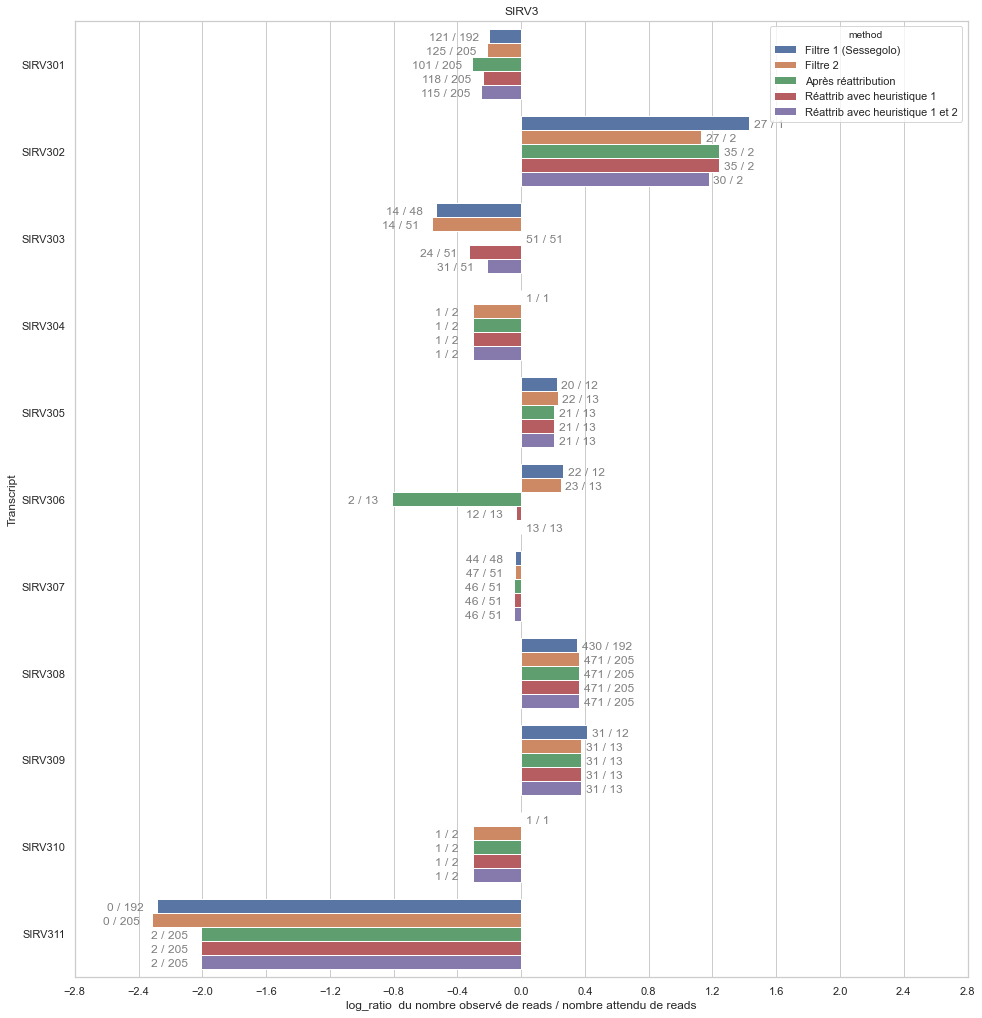

In [21]:
multi_plot_quantif(complete_counts_dict, bam_files["cDNA_ds4_new_basecaller"], TRANSCRIPT_RATIO, "SIRV3",
                   methods = ['filter_1','filter_2','no_heu','heu_1','heu_2'],
                   methods_names = ['Filtre 1 (Sessegolo)', 'Filtre 2', 'Après réattribution', 'Réattrib avec heuristique 1', 'Réattrib avec heuristique 1 et 2']);

In [41]:
chrom_list = sorted(list(set([transcript[:5] for transcript in TRANSCRIPT_RATIO.keys()])))
for bam in bam_files.keys():
    for chrom in chrom_list :
        multi_plot_quantif(complete_counts_dict, bam_files[bam], TRANSCRIPT_RATIO, chrom, methods = ['filter_1','filter_2','no_heu','heu_1','heu_2'], methods_names = ['Filtre 1 (Sessegolo)', 'Filtre 2', 'Après réattribution', 'Réattrib avec heuristique 1', 'Réattrib avec heuristique 1 et 2']);
        plt.close()


In [54]:
chrom_list = sorted(list(set([transcript[:5] for transcript in TRANSCRIPT_RATIO.keys()])))
for bam in bam_files.keys():
    for chrom in chrom_list :
        multi_plot_quantif(complete_counts_dict, bam_files[bam], TRANSCRIPT_RATIO, chrom, methods = ['filter_1','filter_2','no_heu'], methods_names = ['Filtre 1 (Sessegolo)', 'Filtre 2', 'Après réattribution']);
        plt.close()


In [238]:
command = ""
for bam in bam_files.values():
    images = bam[:-3] + "SIRV* "
    command += "convert " + images + bam[:-3] + "pdf && " 
print(command[:-3])

convert BYK_GCA_ONT_1_FAK74085_A.SIRV* BYK_GCA_ONT_1_FAK74085_A.pdf && convert BYK_GCB_ONT_1_FAK69539_A.SIRV* BYK_GCB_ONT_1_FAK69539_A.pdf && convert BYK_GCC_ONT_1_FAK82381_A.basecallHA.SIRV* BYK_GCC_ONT_1_FAK82381_A.basecallHA.pdf && convert BYK_GCB_ONT_1_FAK69539_A.basecallHA.SIRV* BYK_GCB_ONT_1_FAK69539_A.basecallHA.pdf && convert BYK_GDB_ONT_1_PAD67469_A.SIRV* BYK_GDB_ONT_1_PAD67469_A.pdf && convert BYK_GDC_ONT_1_FAL21661_A.SIRV* BYK_GDC_ONT_1_FAL21661_A.pdf && convert BYK_GDB_ONT_1_PAD67469_Aflipflop.SIRV* BYK_GDB_ONT_1_PAD67469_Aflipflop.pdf && convert BYK_GDC_ONT_1_FAL21661_Aflipflop.SIRV* BYK_GDC_ONT_1_FAL21661_Aflipflop.pdf 


In [117]:
preprocess_new_bam("/home/ericcumunel/Documents/Aster/bam/spike_in/treated/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.no_heuristic.bam")

'/home/ericcumunel/Documents/Aster/bam/spike_in/treated/BYK_GCC_ONT_1_FAK82381_A.basecallHA.filtered.new_primary.no_heuristic.sorted.bam'

## Chord Diagram

In [12]:
# def get_switch_countings(switch_dict):
#     switch_counts = dict()
#     for switch in switch_dict.values():
#         source = switch[0]
#         target = switch[1]
#         if source == target or source == None:
#             pass
#         else :
#             if source + " " + target in switch_counts.keys():
#                 switch_counts[source + " " + target] += 1
#             else :
#                 switch_counts[source + " " + target] = 1
#     return switch_counts

def prepare_data_for_chord_diagram(old_sources, old_targets, values):
    all_transcripts = list(set(old_sources + old_targets))
    transcript_id = dict()
    for it, transcript in enumerate(all_transcripts):
        transcript_id[transcript] = it
    sources = []
    for i in old_sources :
        sources.append(transcript_id[i])
    targets = []
    for i in old_targets :
        targets.append(transcript_id[i])
    links = []
    for i in range(0, len(sources)):
        dic = {}
        dic["source"] = sources[i]
        dic["target"] = targets[i]
        dic["value"] = values[i]
        links.append(dic)
    nodes = []
    for i in all_transcripts :
        dic = {}
        dic["name"] = i
        dic["group"] = 1
        nodes.append(dic)
    data = dict()
    data['nodes'] = nodes
    data['links'] = links
    return data
#     switch_countings = get_switch_countings(switch_dict)

def plot_chord_diagram(switch_dict, min_binding_value = 10, chrom = "", output = False):
    sources = []
    targets = []
    values = []
    for k, v in switch_dict.items():
        if v < min_binding_value :
            pass
        else :
            source = k.split()[0]
            target = k.split()[1]
            if source.startswith(chrom) or target.startswith(chrom):
                sources.append(source)
                targets.append(target)
                values.append(v)
    data = prepare_data_for_chord_diagram(sources, targets, values)
    print(sources)

    hv.extension('bokeh')
#     hv.extension('matplotlib')
    hv.output(size=200)
    links = pd.DataFrame(data['links'])
    hv.Chord(links)
    nodes = hv.Dataset(pd.DataFrame(data['nodes']), 'index')
    nodes.data.head()
    chord = hv.Chord((links, nodes)).select(value=(min_binding_value, None))
    show(hv.render(chord.opts(
        opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
                   labels='name', node_color=dim('index').str()))))
#     return chord
#     if output:
        
#         hv.save(chord, 'penguin_adplot.png', fmt='png')

In [13]:
# print(complete_switch_dict[bam_files["dRNA_ds3"]]["no_heu"])

['SIRV708', 'SIRV706', 'SIRV704', 'SIRV703', 'SIRV701', 'SIRV705', 'SIRV702', 'SIRV701', 'SIRV702', 'SIRV702', 'SIRV703', 'SIRV703']


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
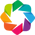

In [14]:
plot_chord_diagram(complete_switch_dict[bam_files["dRNA_ds3"]]["heu_1"], min_binding_value = 5, chrom = "SIRV7", output = True)

In [16]:
# import holoviews as hv
# from holoviews import opts
# from holoviews.operation import contours
# hv.extension('matplotlib')
# hv.save(test, 'penguin_plot.png', fmt='svg')

# # hv.output(test, "test.png")

## Couverture des transcripts par position

In [2]:
def plot_coverage_per_position(bam_file, transcript):
    alignment_file = pysam.AlignmentFile(PATH_TO_BAM + bam_file)
    coverage_per_position = []
    for pileupcolumn in alignment_file.pileup(contig=transcript, truncate=True, max_depth=10000000):
        coverage_per_position.append(pileupcolumn.n)
    len_transcript = len(coverage_per_position)
    ax = sns.lineplot(x=range(0,len_transcript),y=coverage_per_position).set_title(transcript)
    plt.xlabel('Transcript position')
    plt.ylabel('Coverage')
    image_name = PATH_TO_PLOT + bam_file[:-3] + transcript + ".png"
    plt.savefig(image_name)
    plt.show()
#     ax.set(xlabel='common xlabel', ylabel='common ylabel')ax.set(xlabel="X Label", ylabel = "Y Label") 
#     return len_transcript
    

    
def plot_all_transcripts(alignment_file):
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    transcript_names = alignment_file.header.references
    sub_transcript_list = []
    for transcript in transcript_names :
        if transcript.startswith("SIRV10"):
            sub_transcript_list.append(transcript)
    for i, transcript in enumerate(sub_transcript_list) :
            logging.info("Treating " + transcript + "...")
            nb_line = len(sub_transcript_list)/4
            if len(sub_transcript_list)%4 != 0 :
                nb_line += 1
            ax = fig.add_subplot(nb_line, 4, i+1)
            plot_coverage_per_position(alignment_file, transcript)
    plt.show()

def plot_coverage_diff(alignment_file1, alignment_file2, transcript):
    plot_coverage_per_position(alignment_file1, transcript)
    plot_coverage_per_position(alignment_file2, transcript)

def plot_all_coverage(alignment_file1, alignment_file2):
    transcript_names = alignment_file1.header.references
    for transcript in transcript_names :
        if transcript.startswith("SIRV2"):
            print(transcript)
            plt.figure()
            plot_coverage_diff(alignment_file1, alignment_file2, transcript)
            
def plot_all_coverage(alignment_file1, alignment_file2):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    transcript_names = alignment_file1.header.references
    i=0
    for transcript in transcript_names :
        if transcript.startswith("SIRV2"):
            if i >= 9 :
                break
            i+=1
            print(transcript)
            ax = fig.add_subplot(3, 3, i)
            plot_coverage_diff(alignment_file1, alignment_file2, transcript)
    plt.show()
    
def preprocess_new_bam(new_bamfile):
    print(new_bamfile)
    sorted_new_bamfile = new_bamfile[:-3] + "sorted.bam"
    if not os.path.isfile(sorted_new_bamfile) :
        logging.info("Sorting new file...")
        pysam.sort(new_bamfile, "-o", sorted_new_bamfile)
        logging.info("Sorting new file DONE")

    if not os.path.isfile(sorted_new_bamfile + ".bai") :
        logging.info("Indexing...")
        pysam.index(sorted_new_bamfile)
        logging.info("Indexing DONE")
    else :
        logging.info("The index already exist")
    return sorted_new_bamfile

In [ ]:
preprocess_new_bam(PATH_TO_BAM + "BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC.bam")

/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC.bam


In [99]:
af = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.sorted.bam")

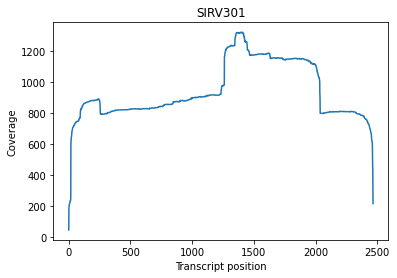

In [14]:
plot_coverage_per_position("BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC.sorted.bam", "SIRV301")

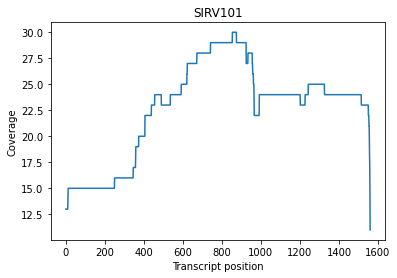

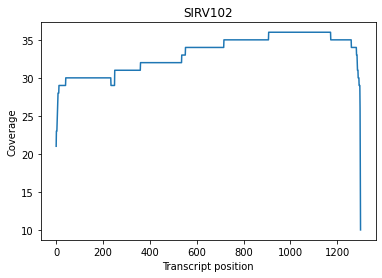

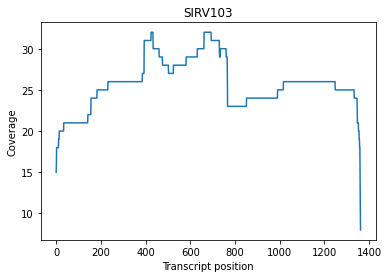

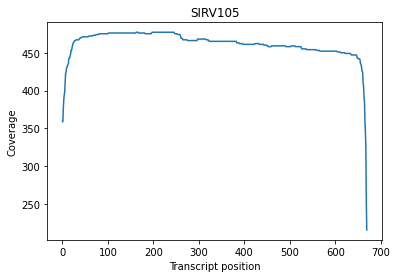

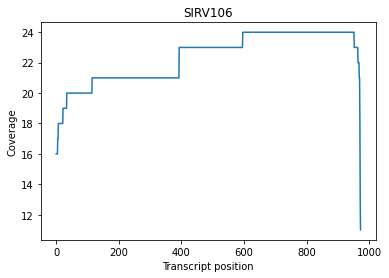

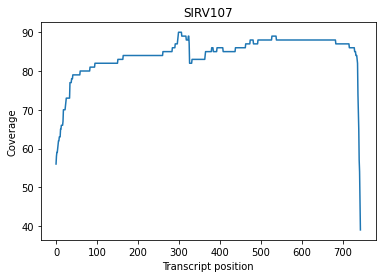

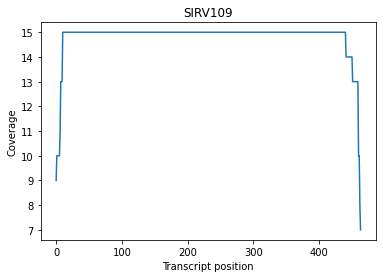

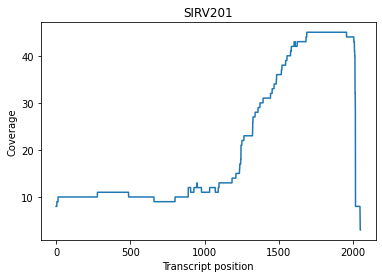

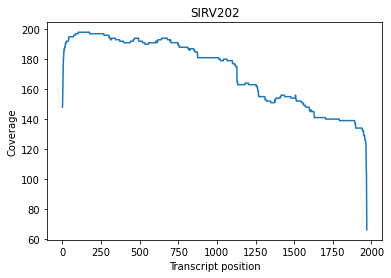

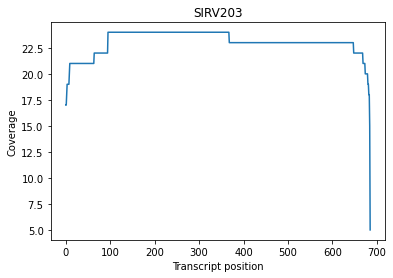

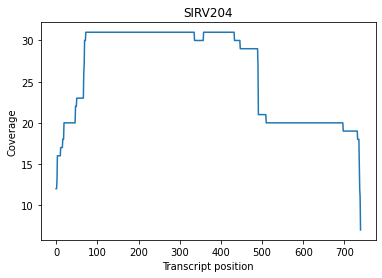

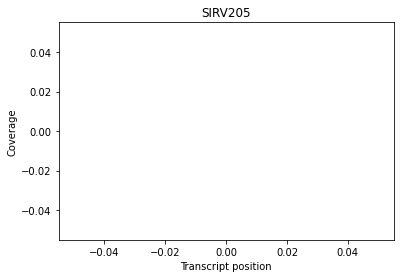

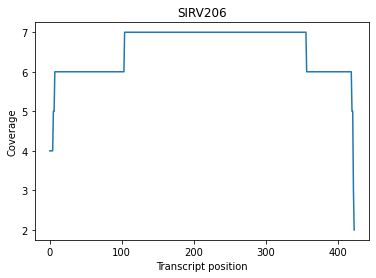

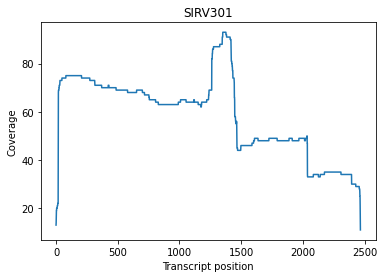

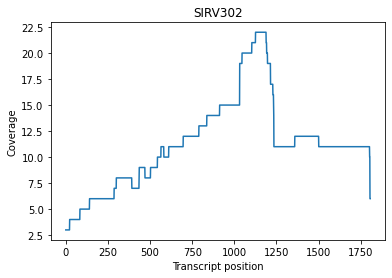

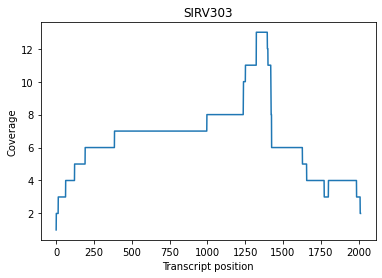

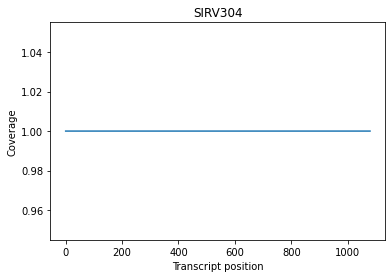

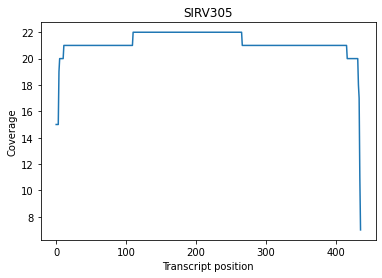

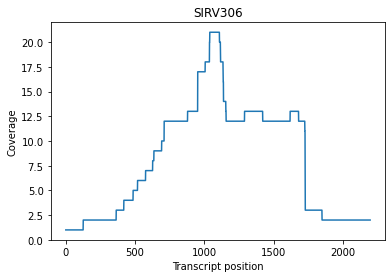

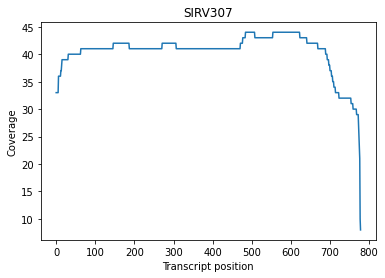

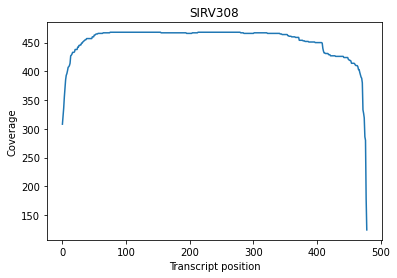

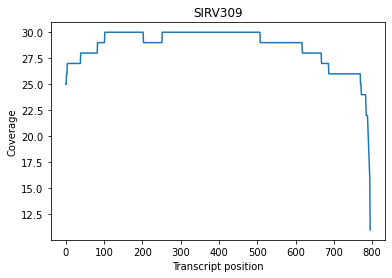

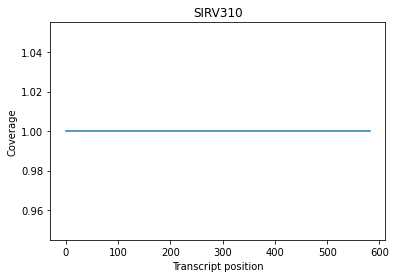

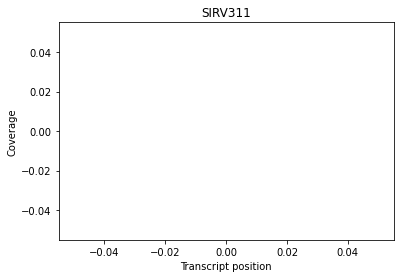

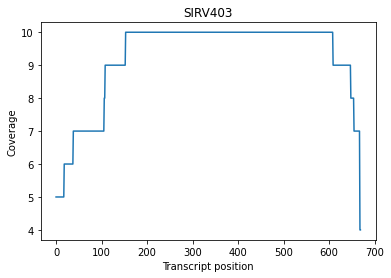

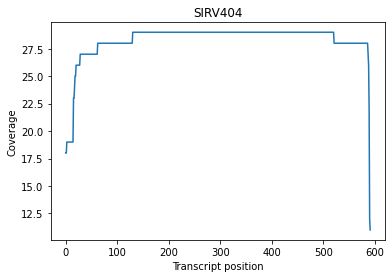

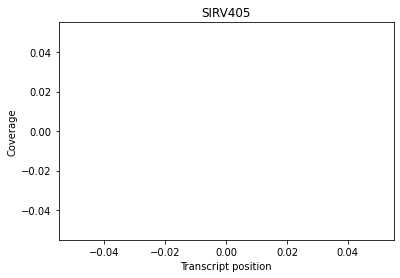

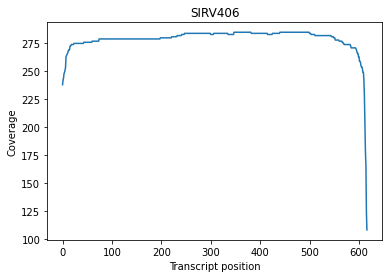

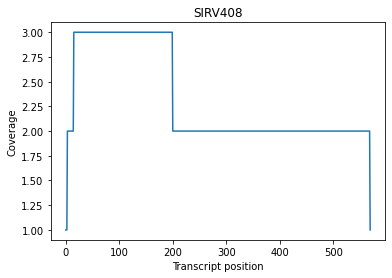

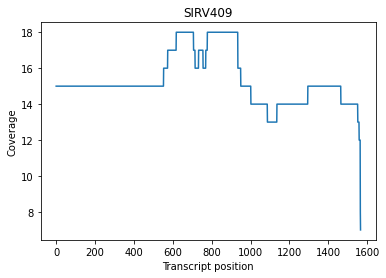

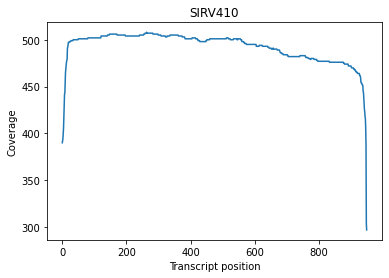

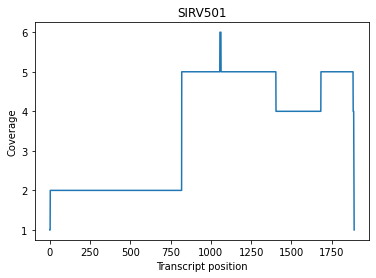

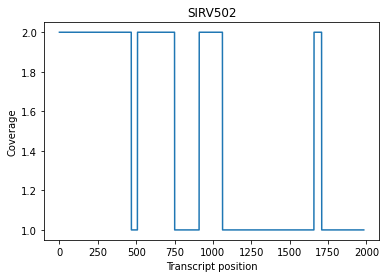

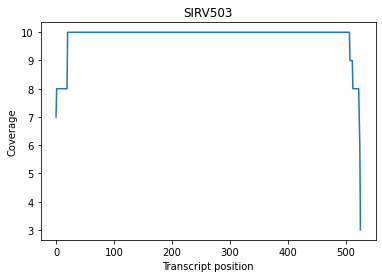

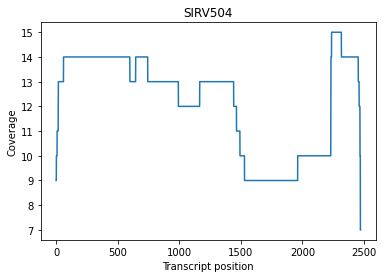

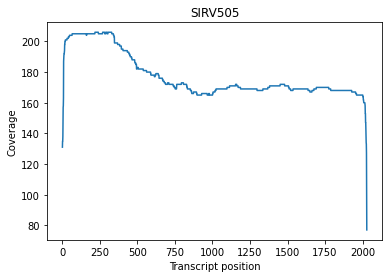

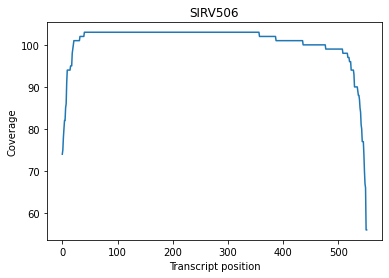

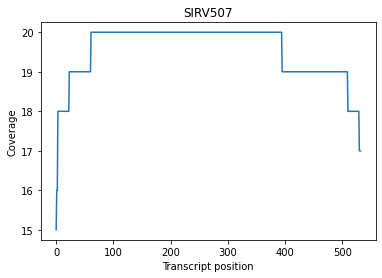

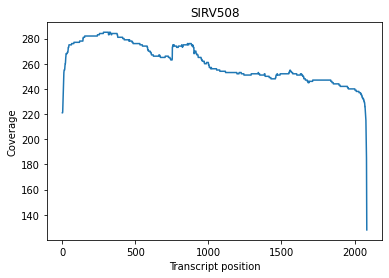

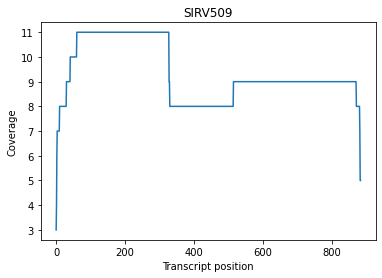

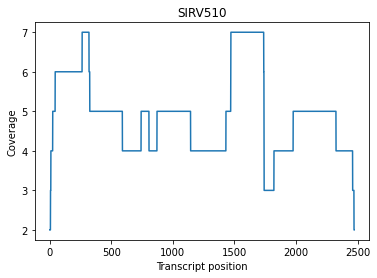

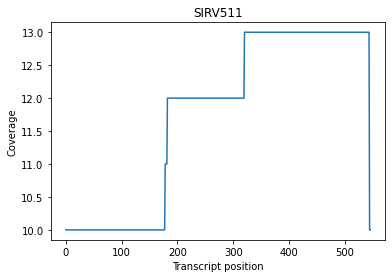

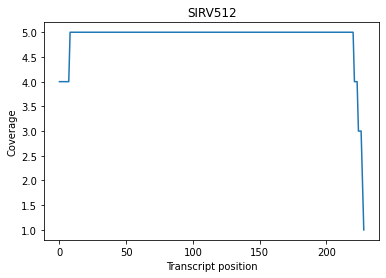

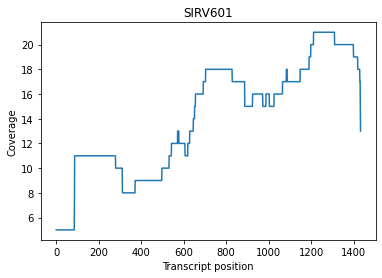

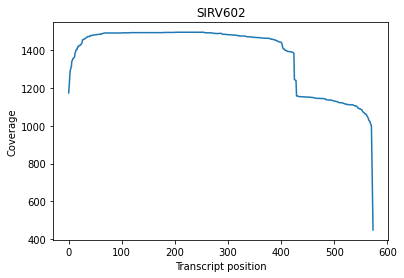

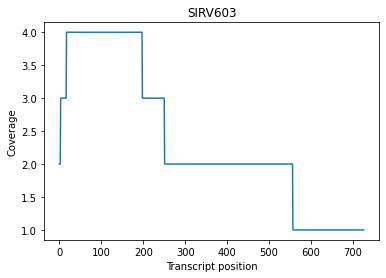

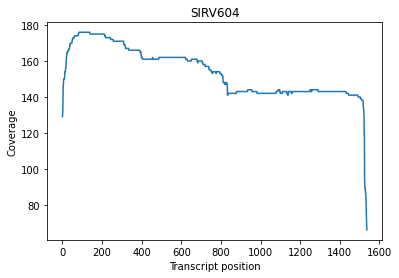

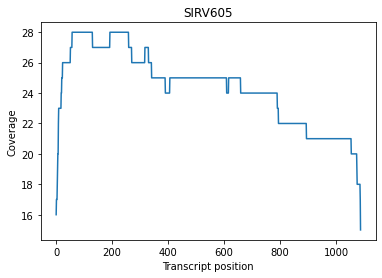

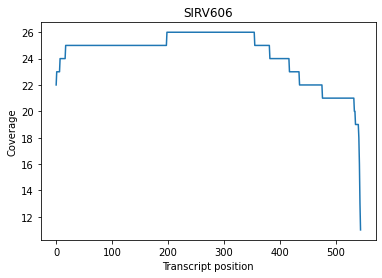

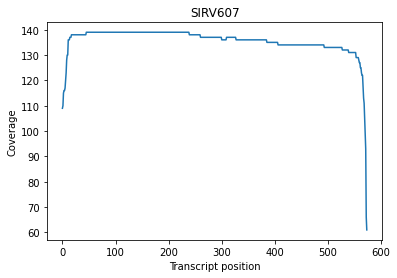

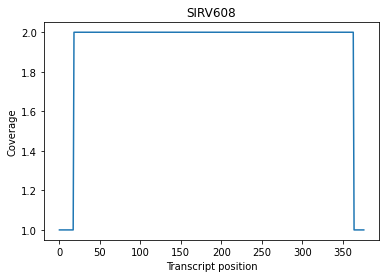

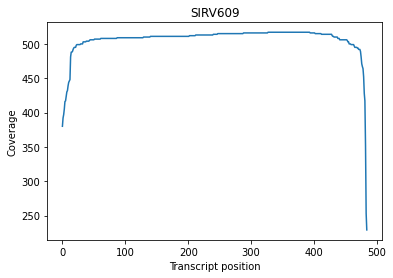

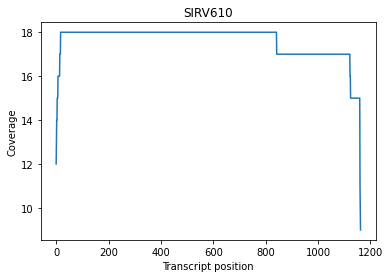

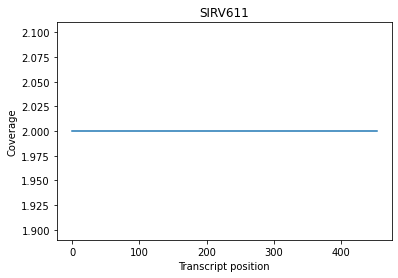

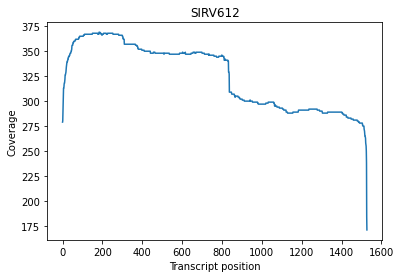

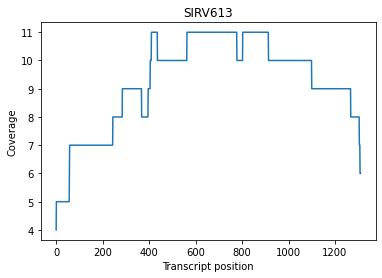

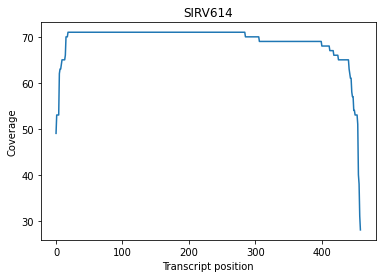

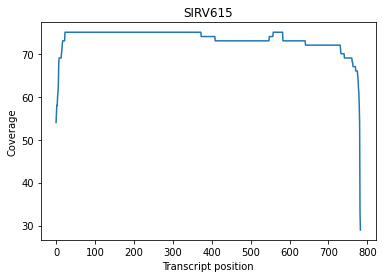

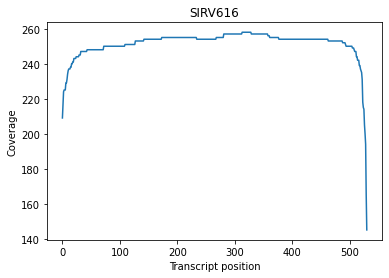

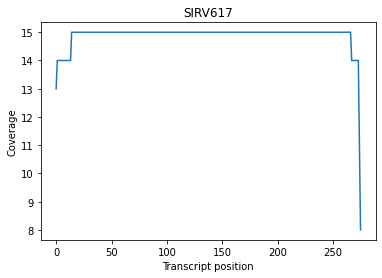

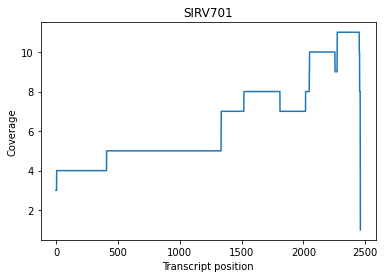

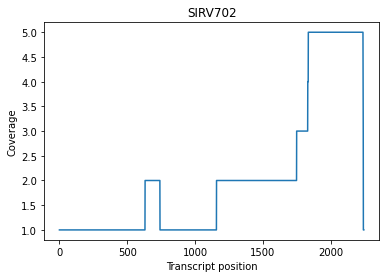

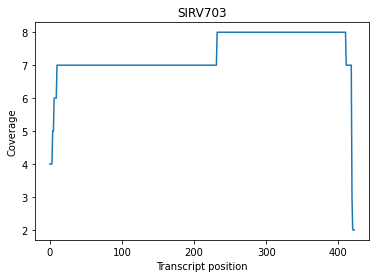

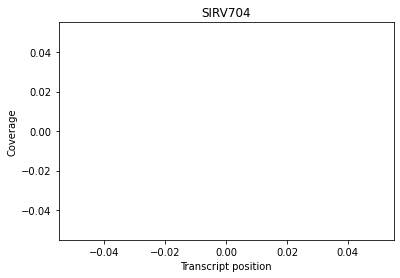

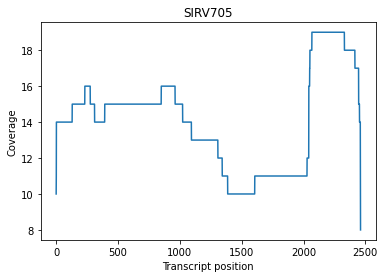

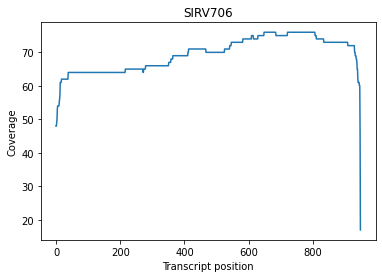

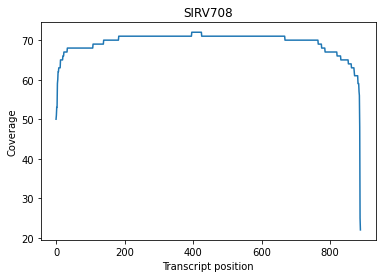

In [17]:
for transcript in TRANSCRIPT_RATIO.keys():
    plot_coverage_per_position("BYK_GDB_ONT_1_PAD67469_Aflipflop.filtered_80QC.sorted.bam", transcript)

['SIRV1', 'SIRV2', 'SIRV3', 'SIRV4', 'SIRV5', 'SIRV6', 'SIRV7']
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV1
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV2
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV3
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV4
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV5
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV6
BYK_GCA_ONT_1_FAK74085_A.bam
SIRV7
BYK_GCA_ONT_1_FAK74085_A.bam
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV1
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV2
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV3
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV4
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV5
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV6
BYK_GCB_ONT_1_FAK69539_A.bam
SIRV7
BYK_GCB_ONT_1_FAK69539_A.bam
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV1
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV2
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV3
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV4
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV5
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV6
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam
SIRV7
BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam


/home/ericcumunel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV1
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV2
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV3
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV4
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV5
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV6
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
SIRV7
BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV1
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV2
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV3
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV4
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV5
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV6
BYK_GDB_ONT_1_PAD67469_A.bam
SIRV7
BYK_GDB_ONT_1_PAD67469_A.bam
BYK_GDC_ONT_1_FAL21661_A.bam
SIRV1
BYK_GDC_ONT_1_FAL21661_A.bam


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



SIRV2
BYK_GDC_ONT_1_FAL21661_A.bam
Traceback (most recent call last):
  File "/home/ericcumunel/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-77544414d055>", line 16, in <module>
    df = multi_plot_quantif(complete_counts_dict, bam, TRANSCRIPT_RATIO, chrom);
  File "<ipython-input-10-7d58be63bc08>", line 20, in multi_plot_quantif
    counts_ratio.append(math.log10(ratio))
ValueError: math domain error

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ericcumunel/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ericcumu

ValueError: math domain error

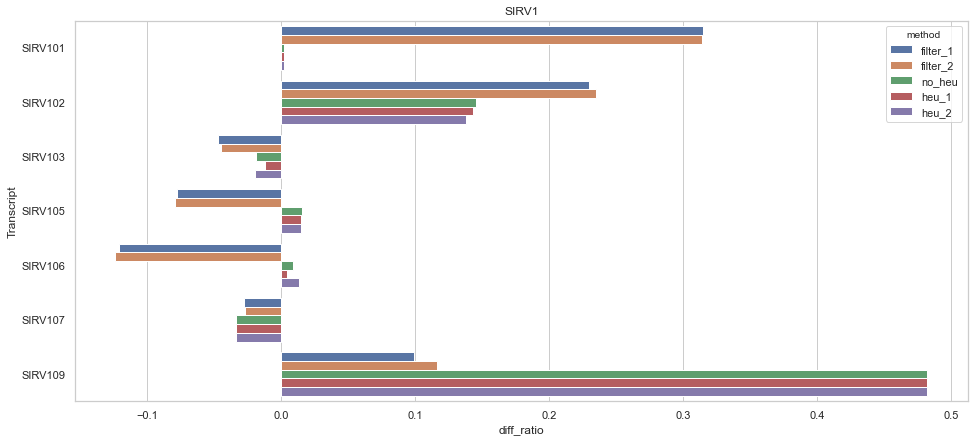

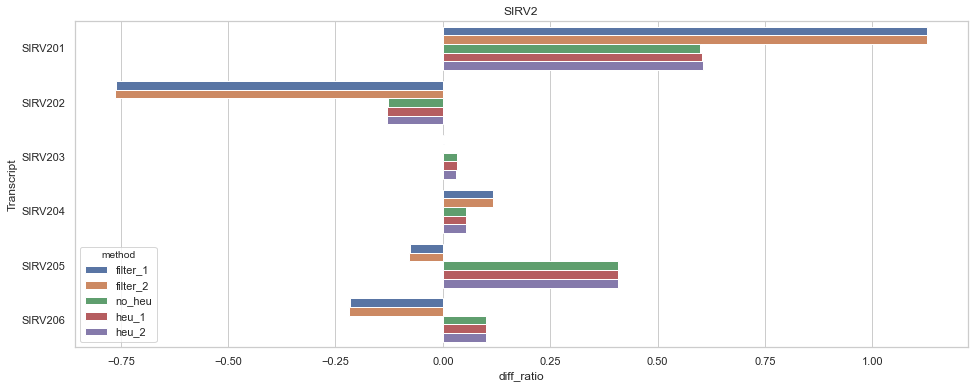

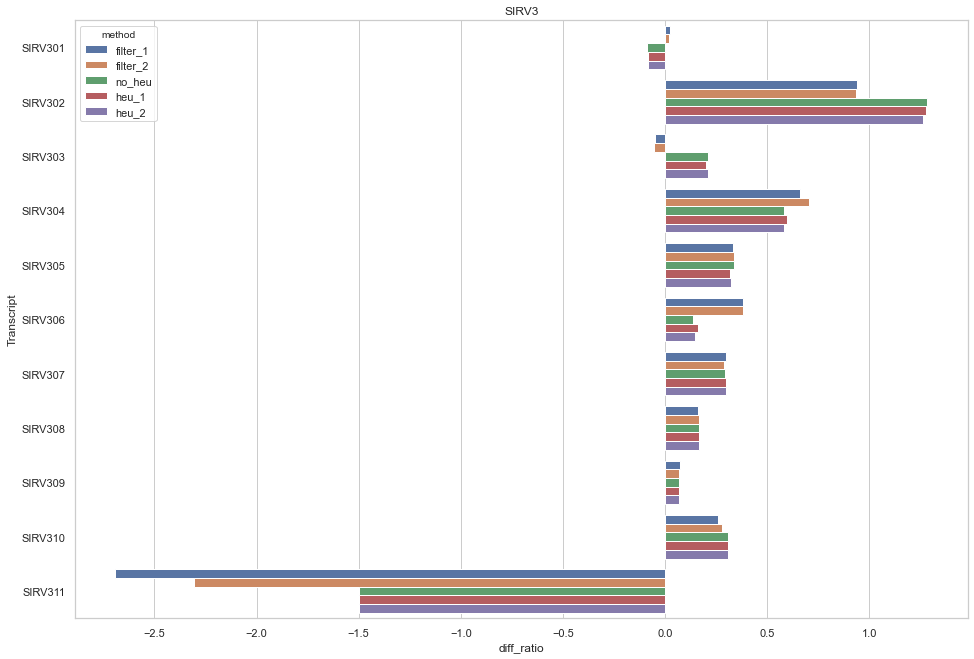

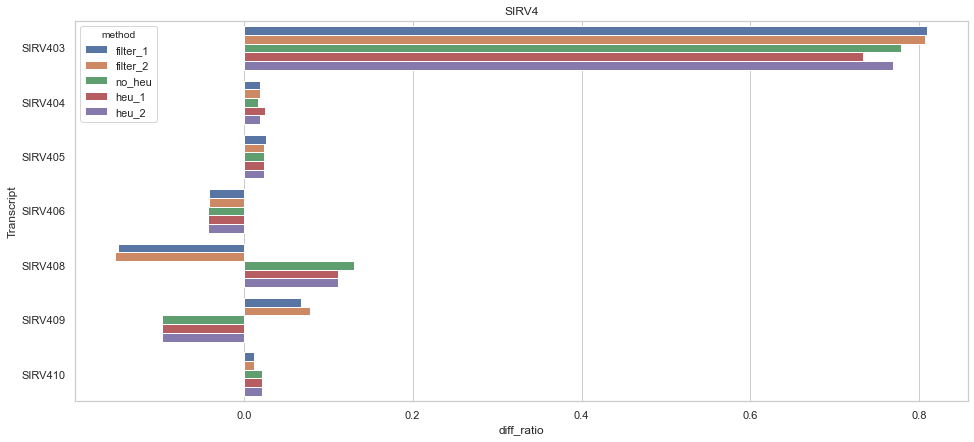

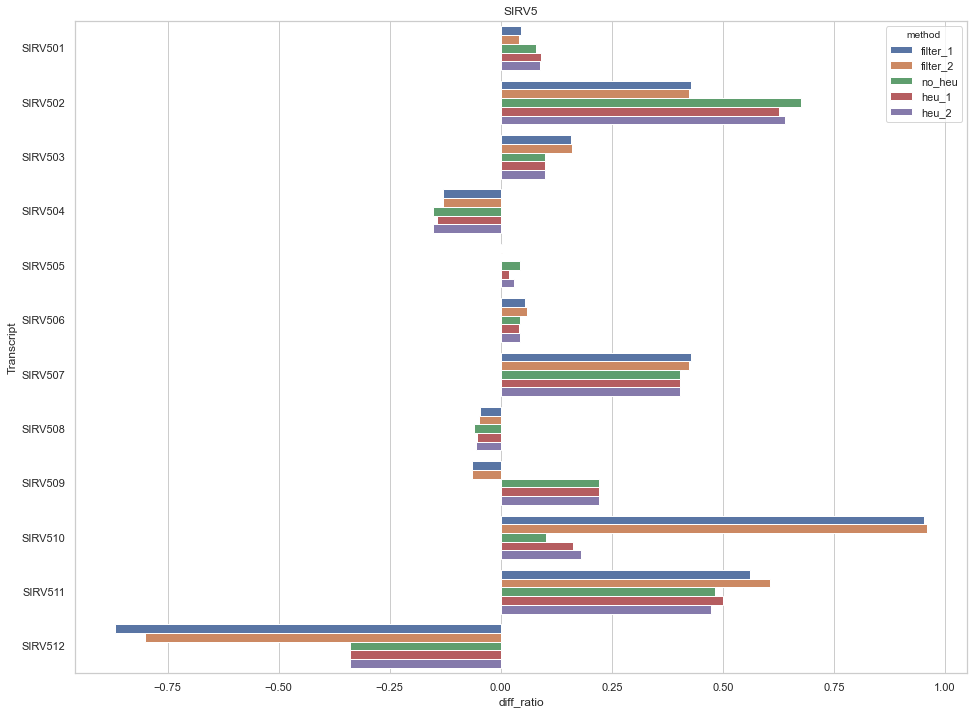

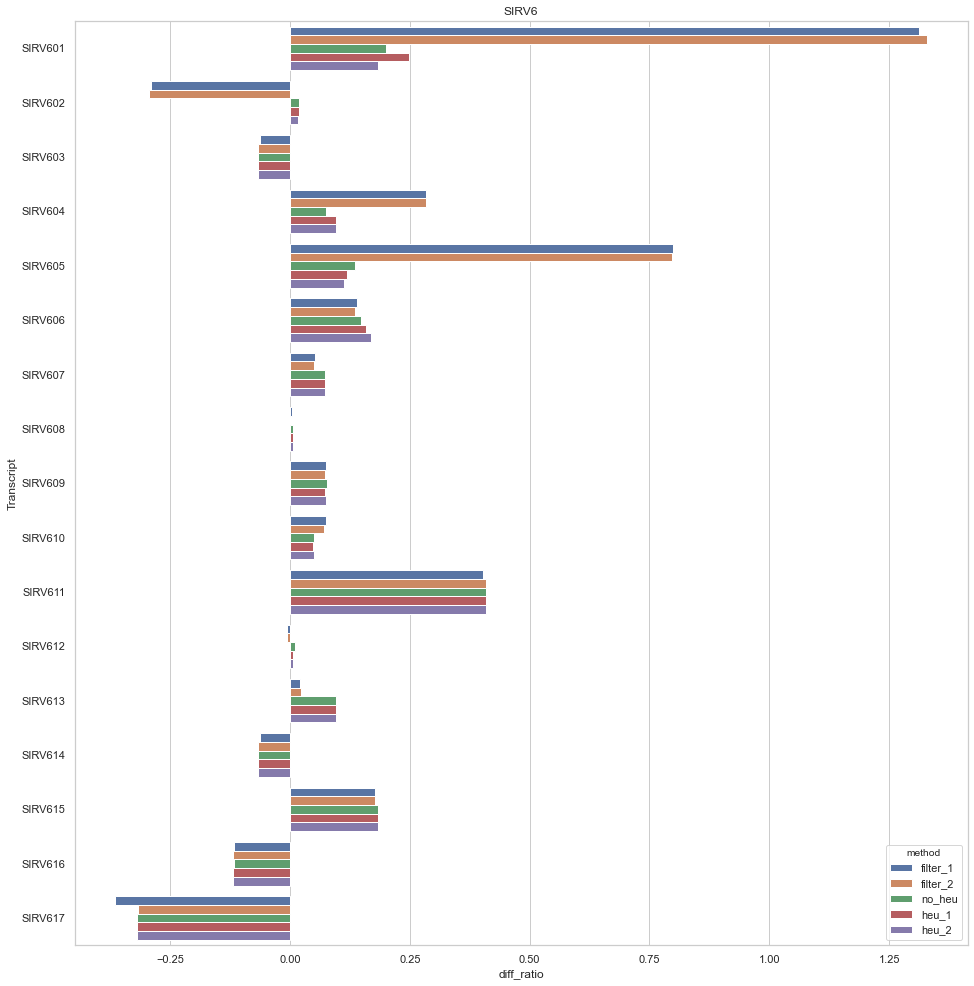

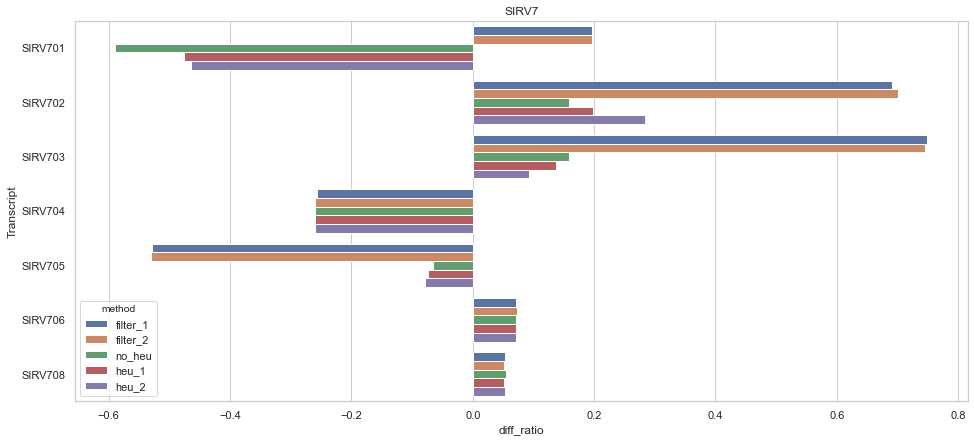

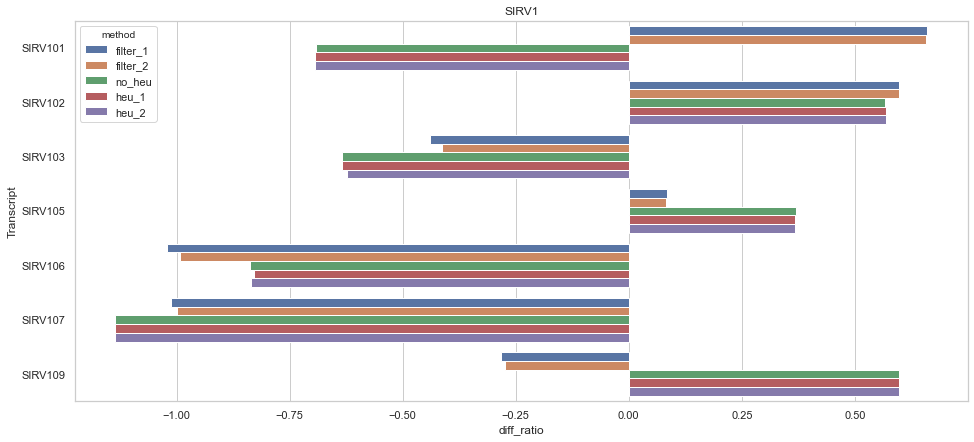

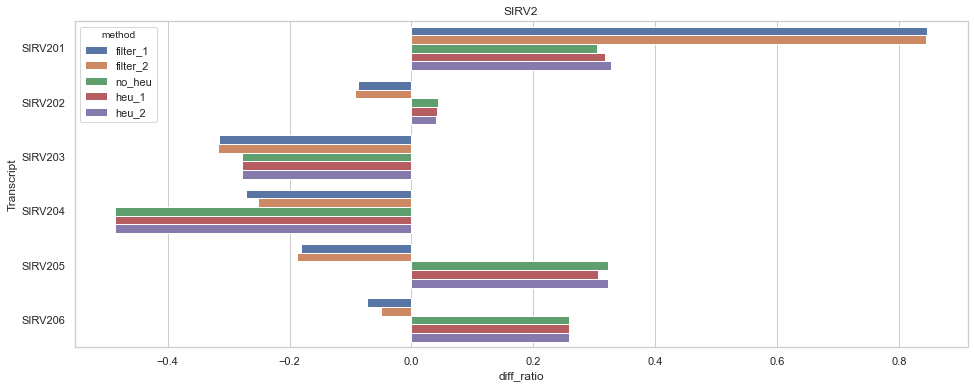

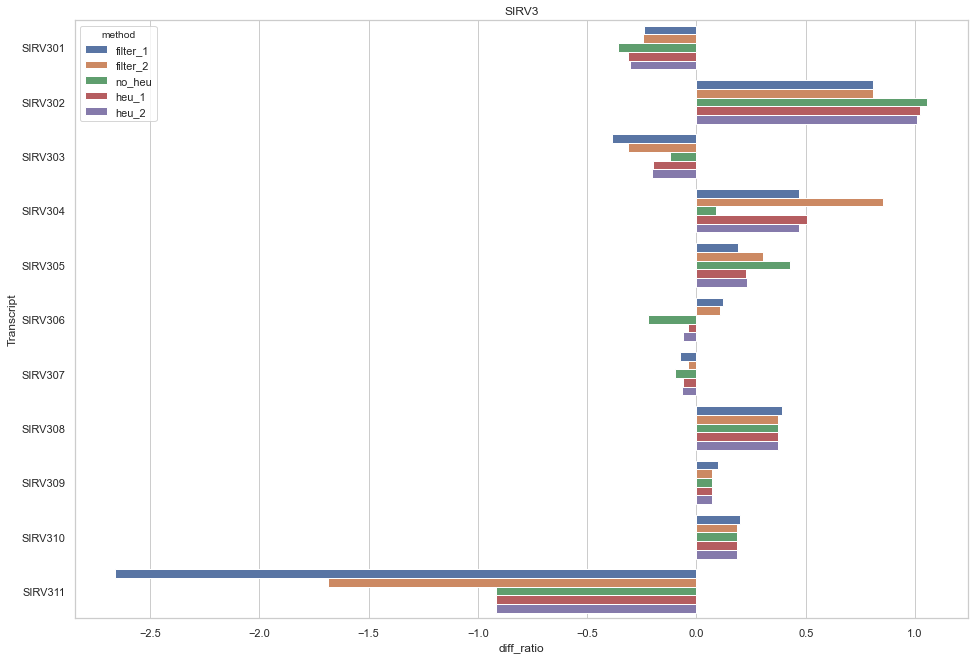

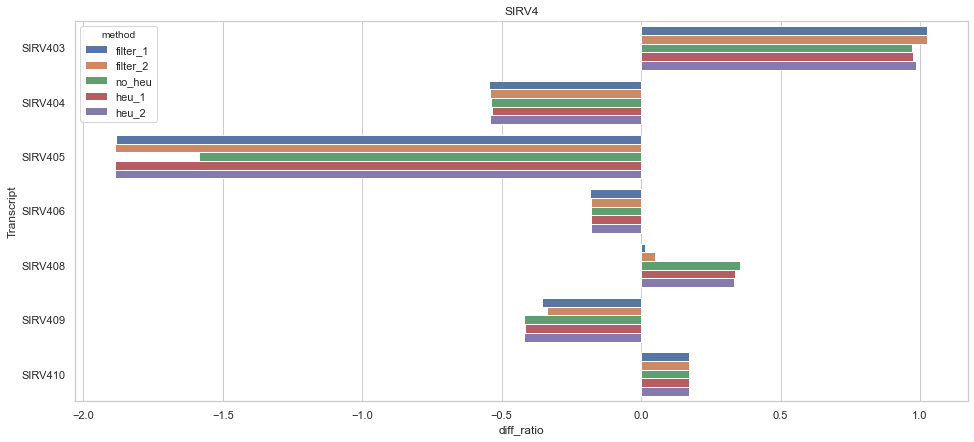

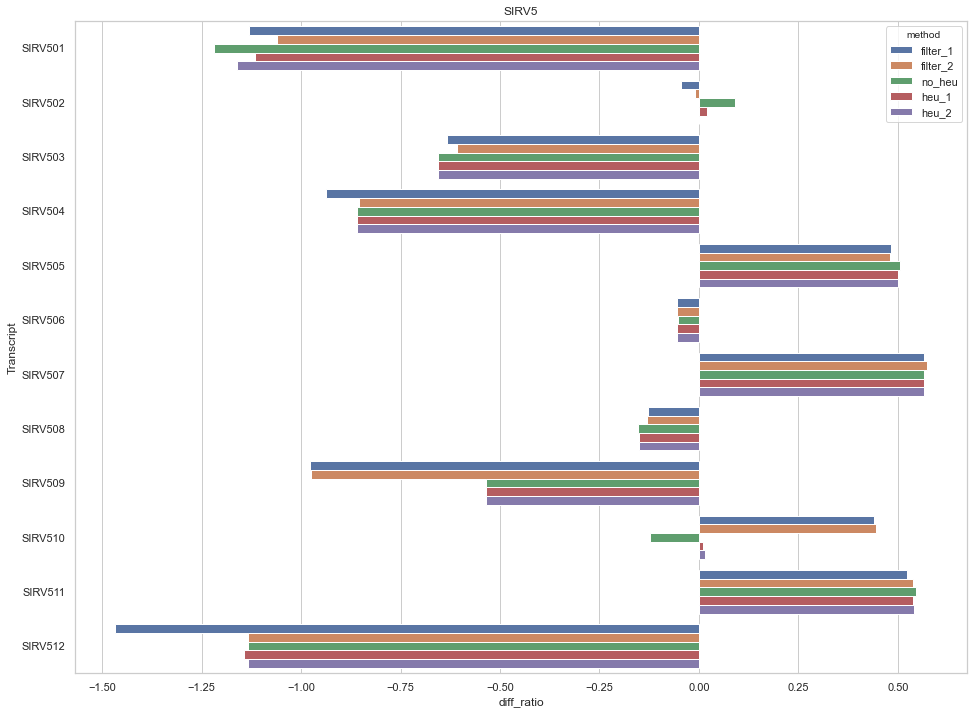

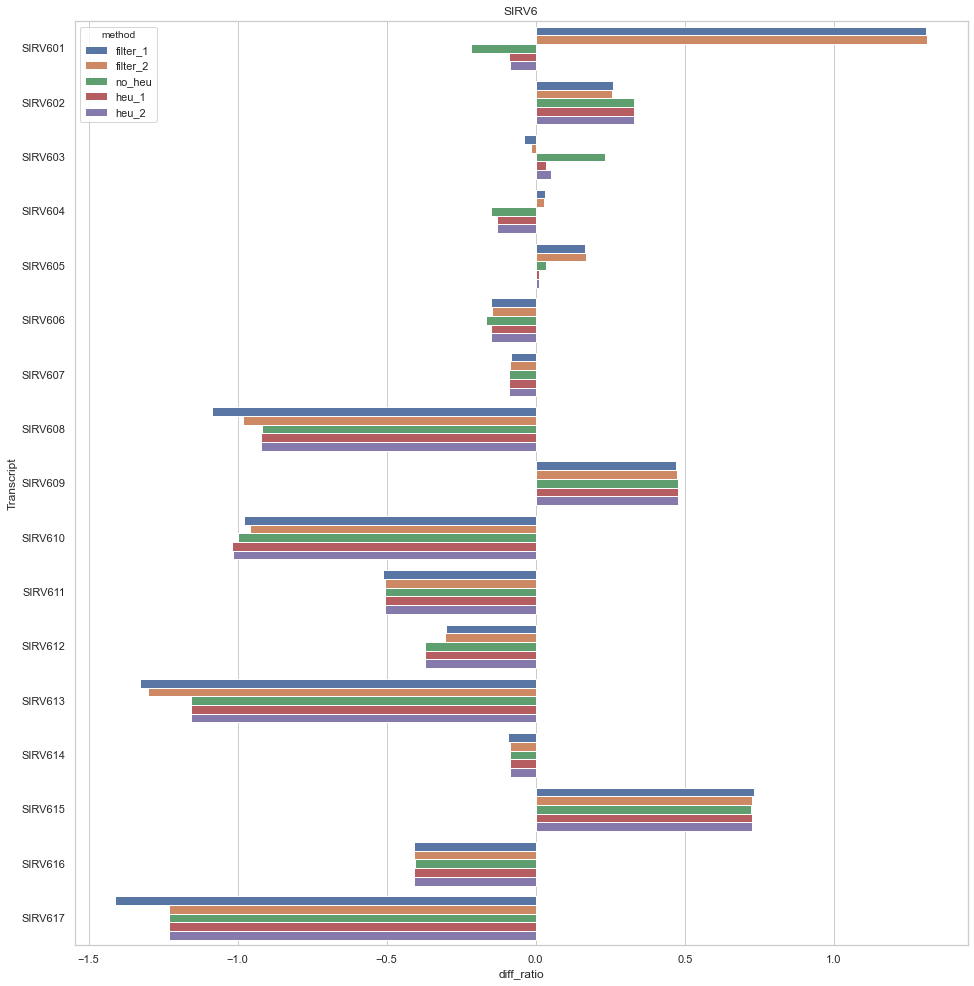

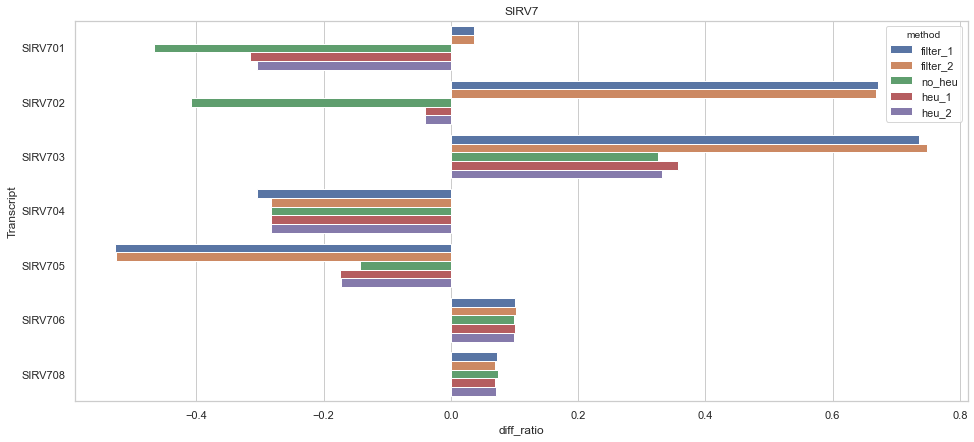

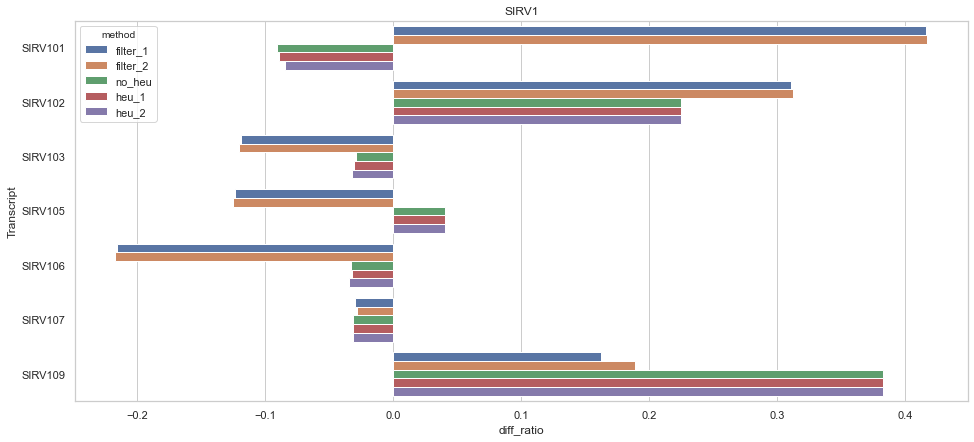

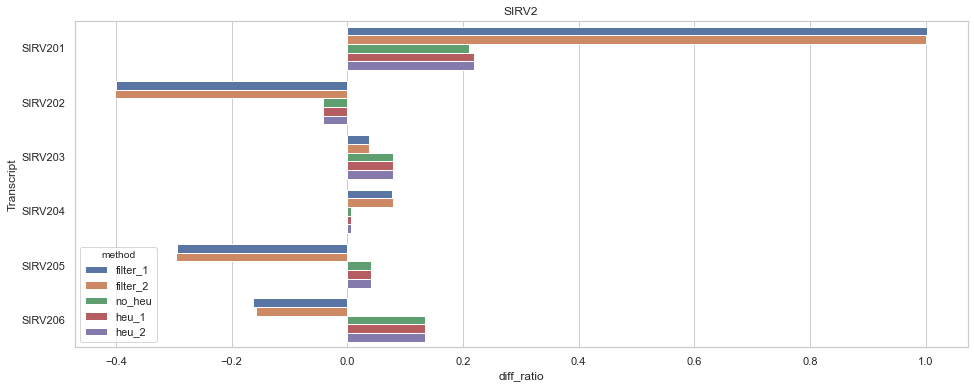

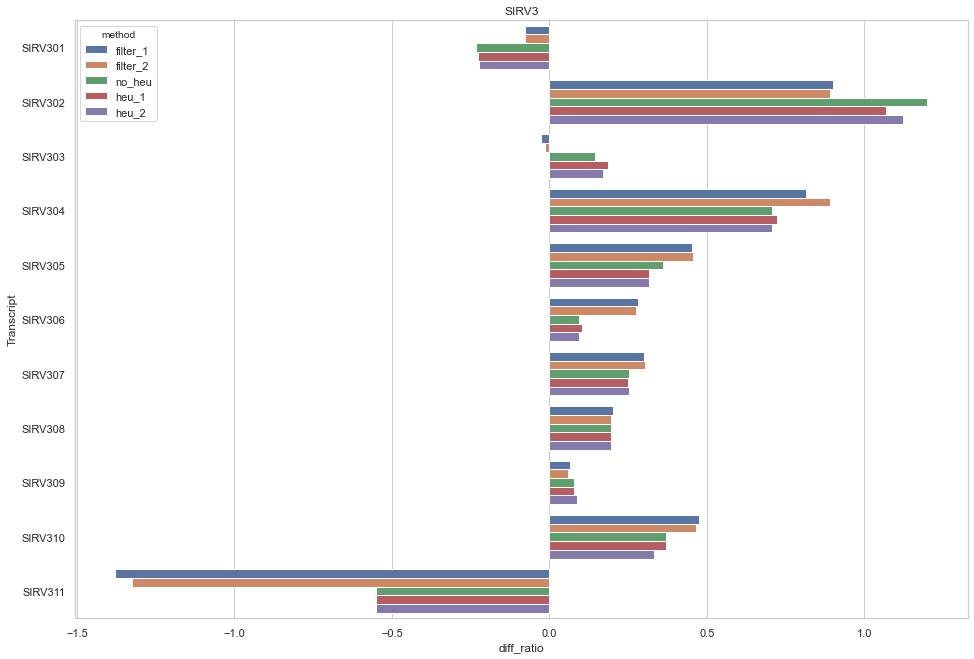

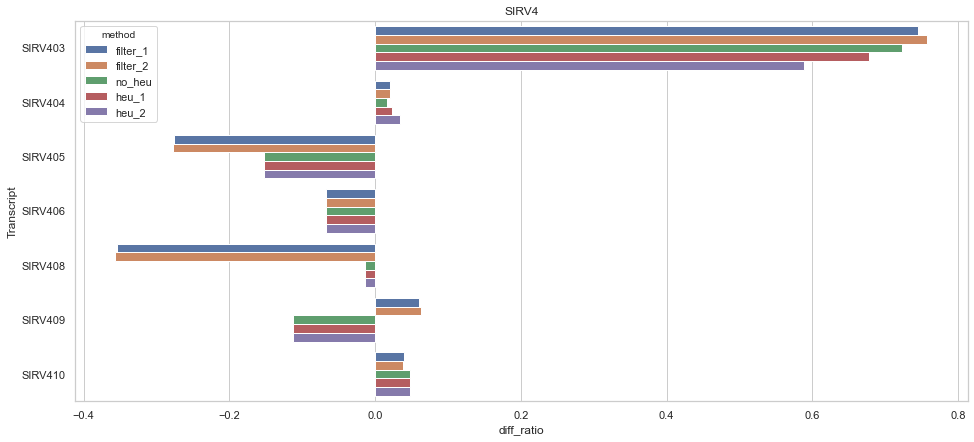

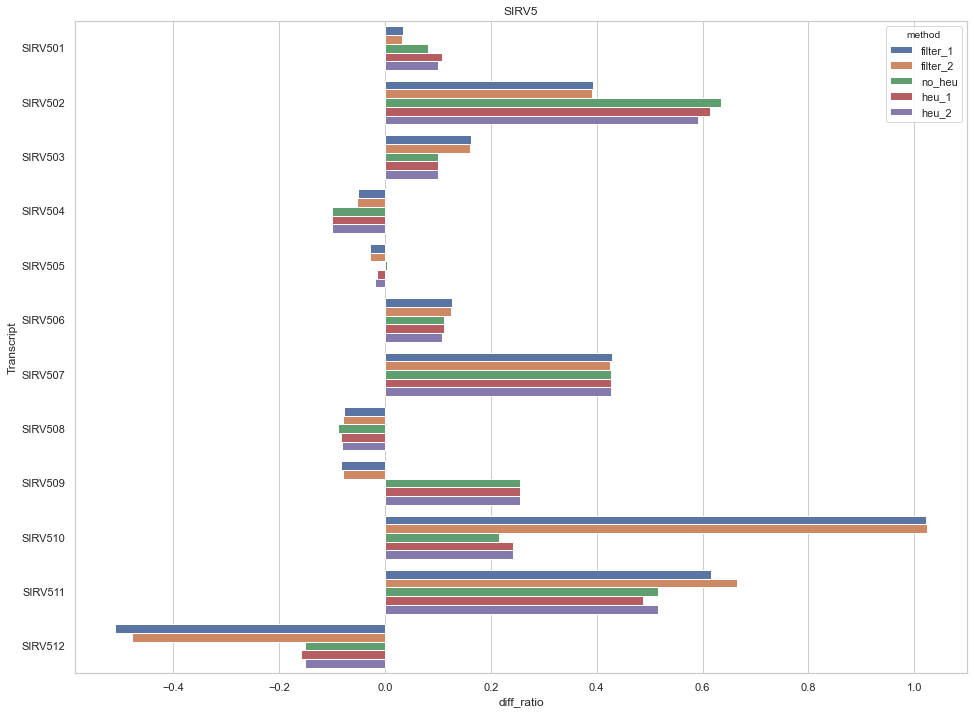

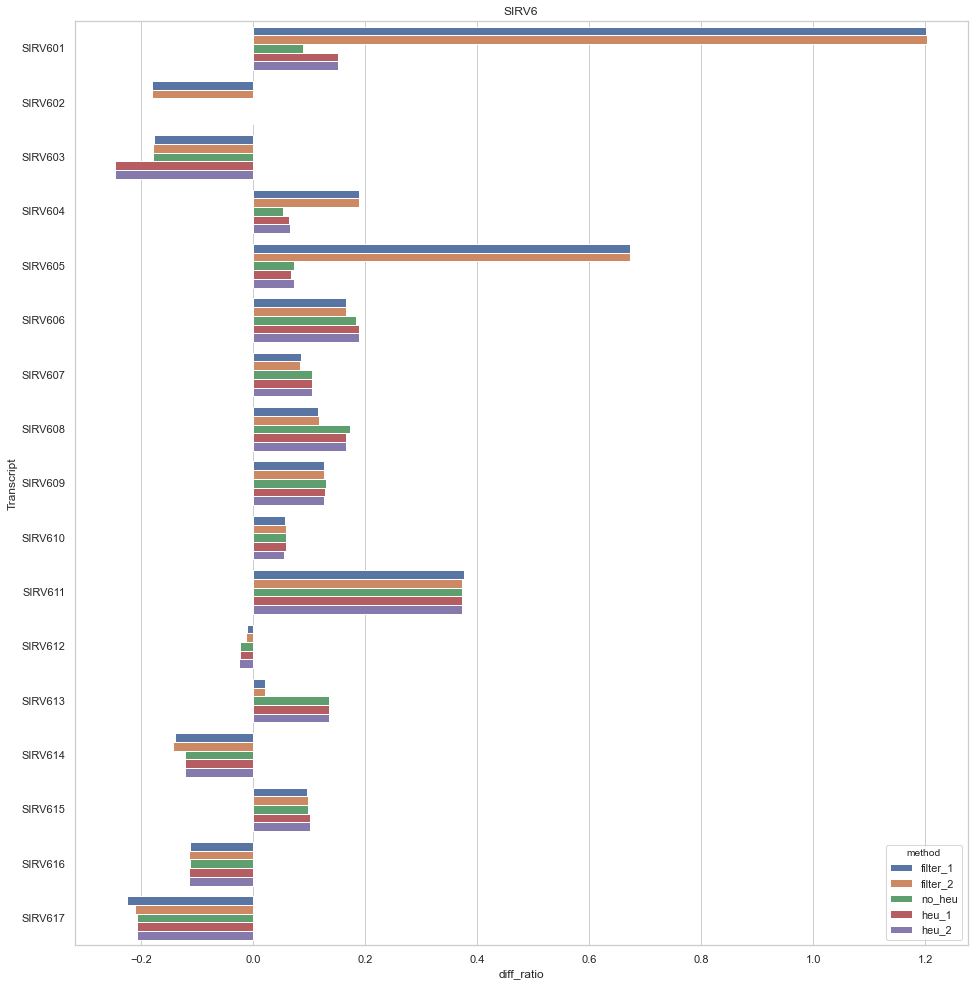

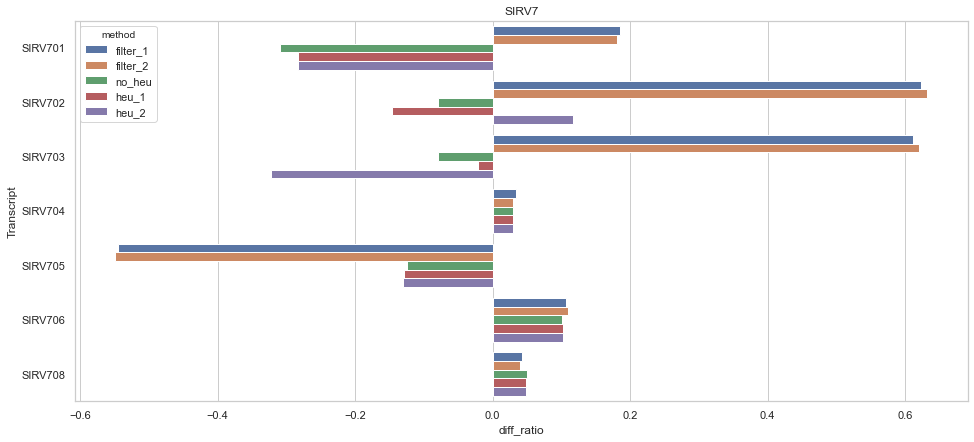

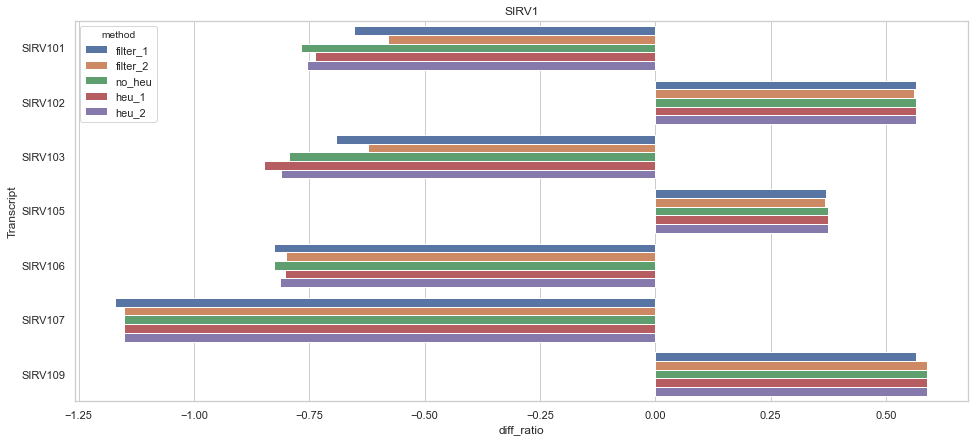

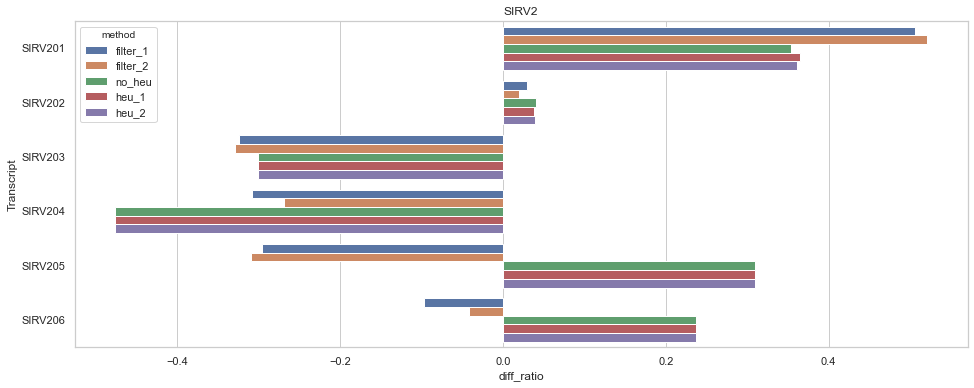

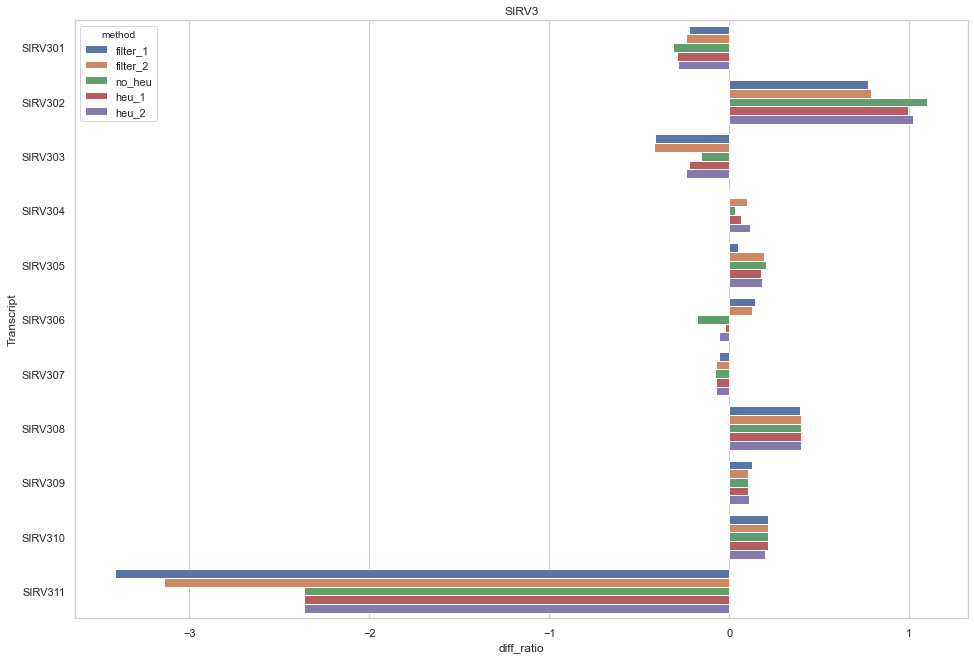

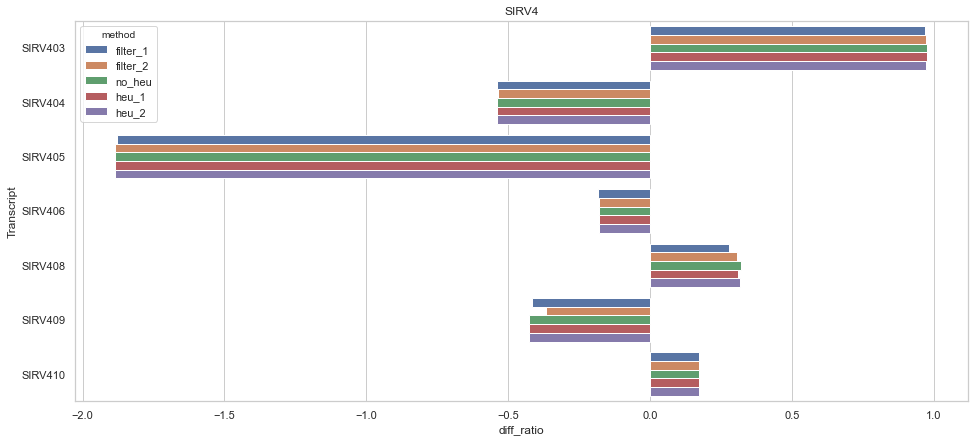

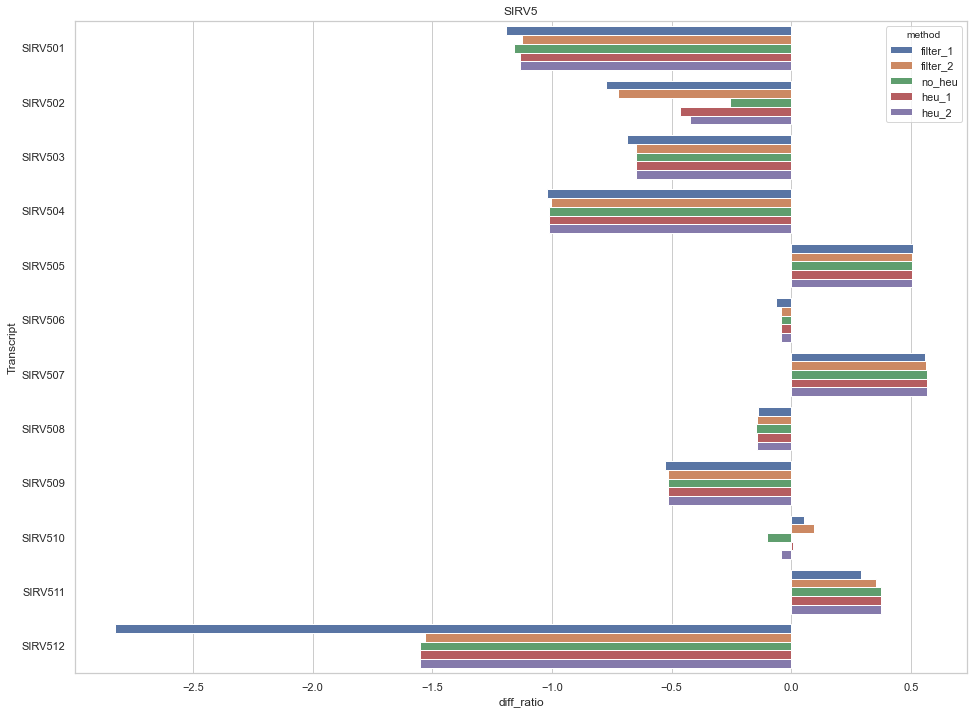

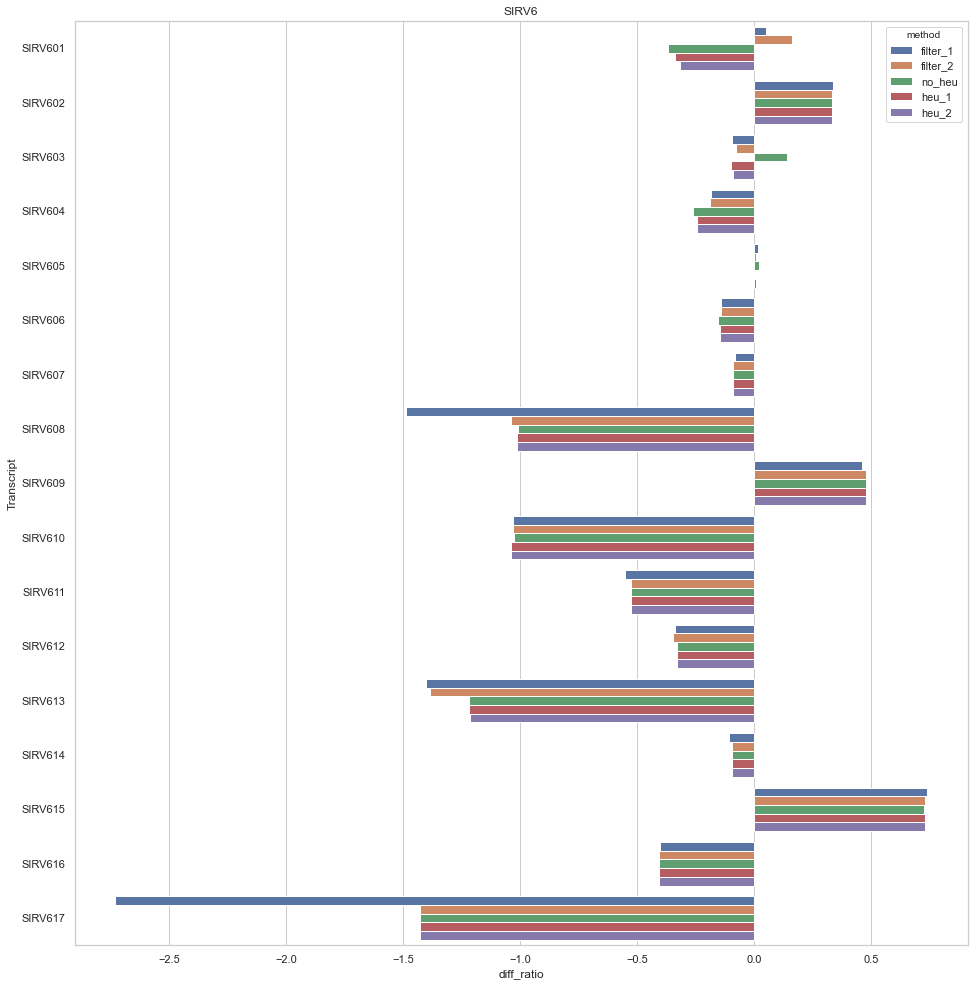

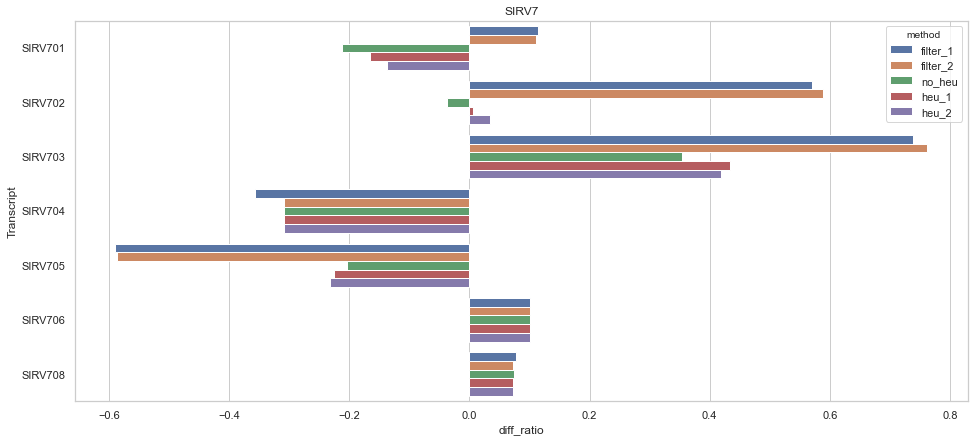

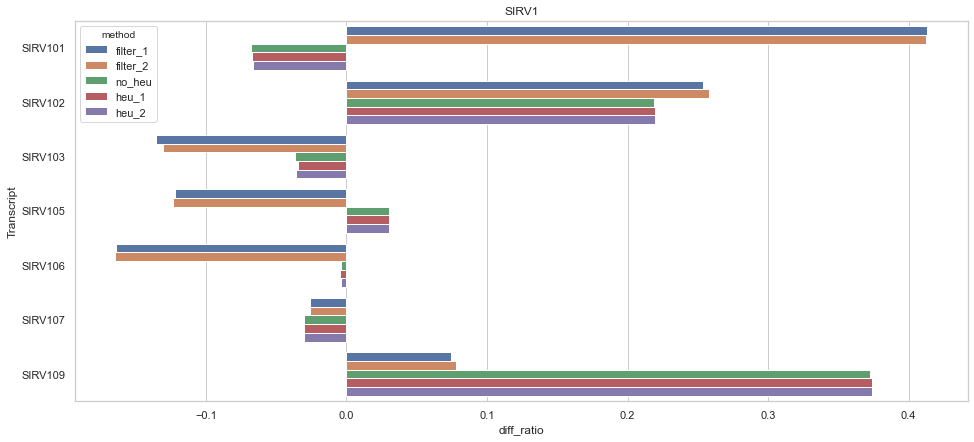

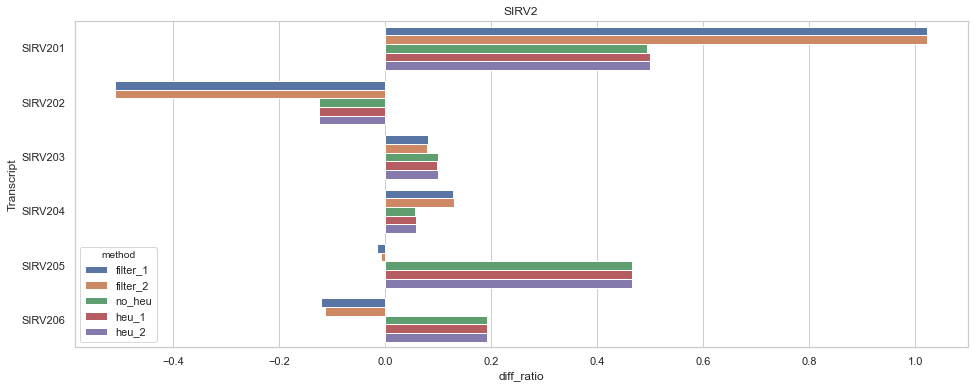

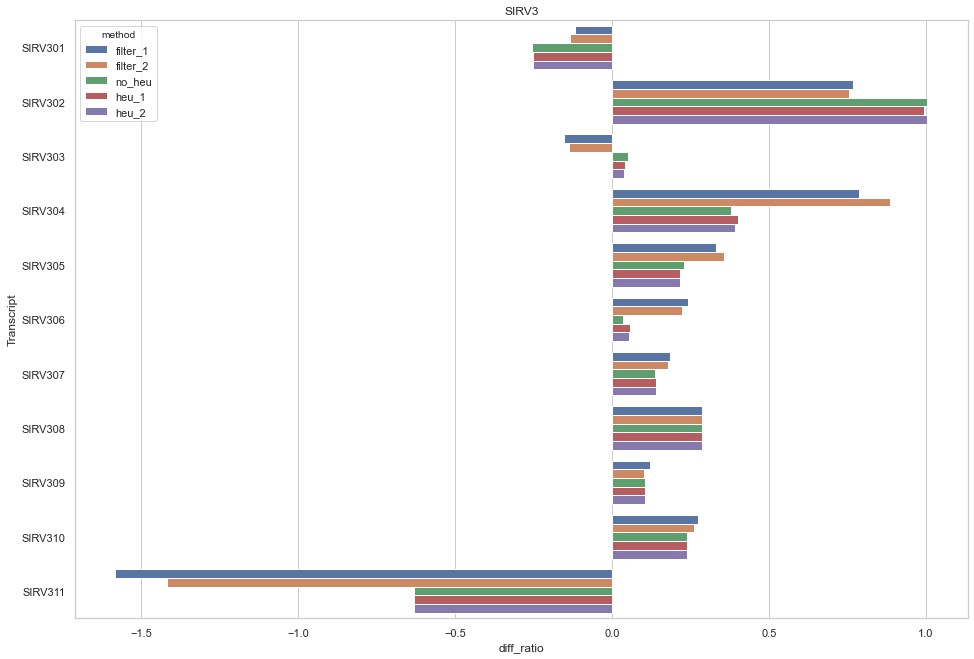

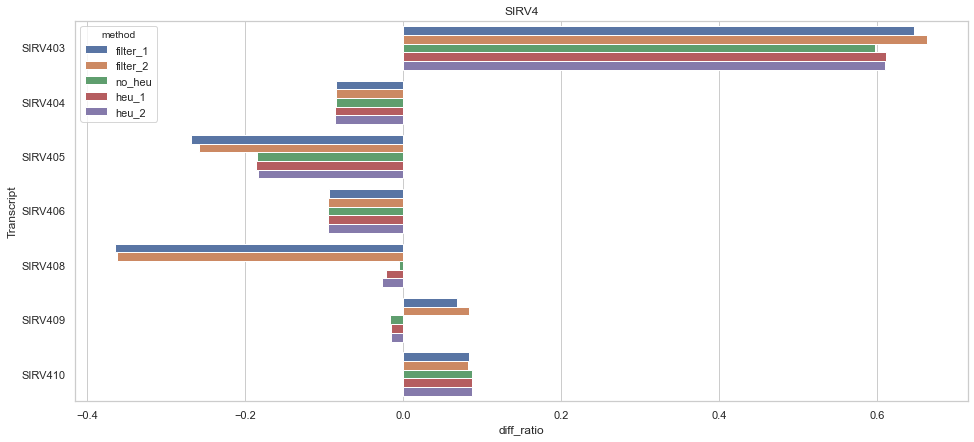

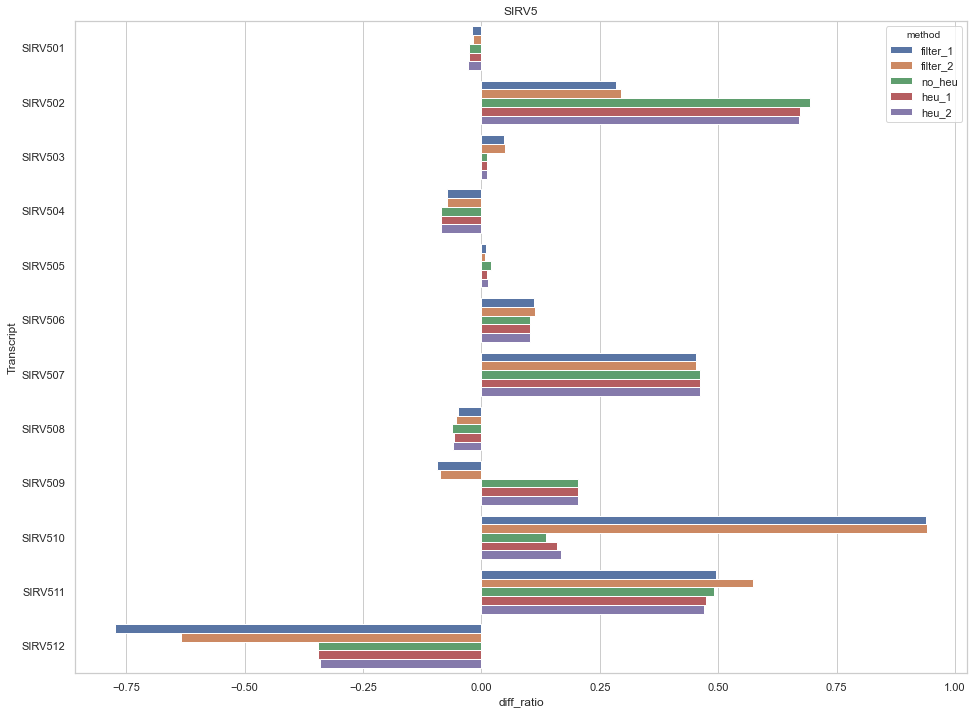

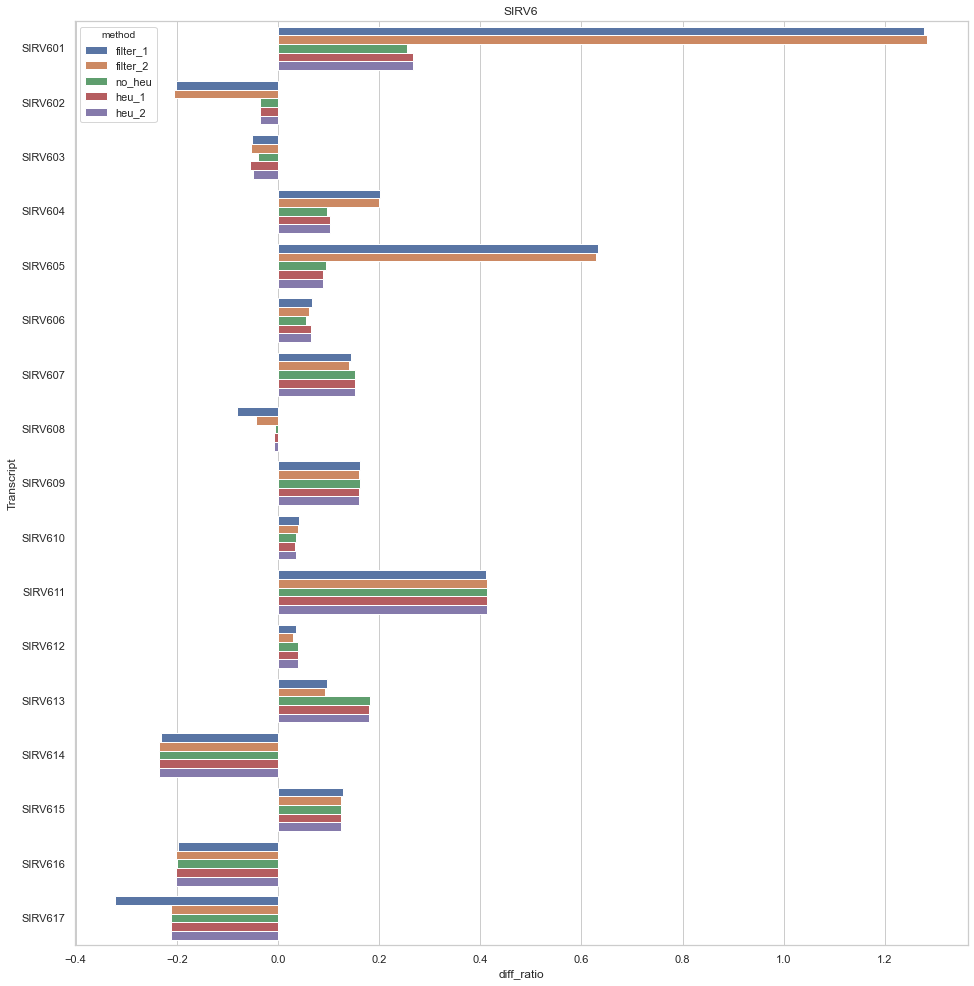

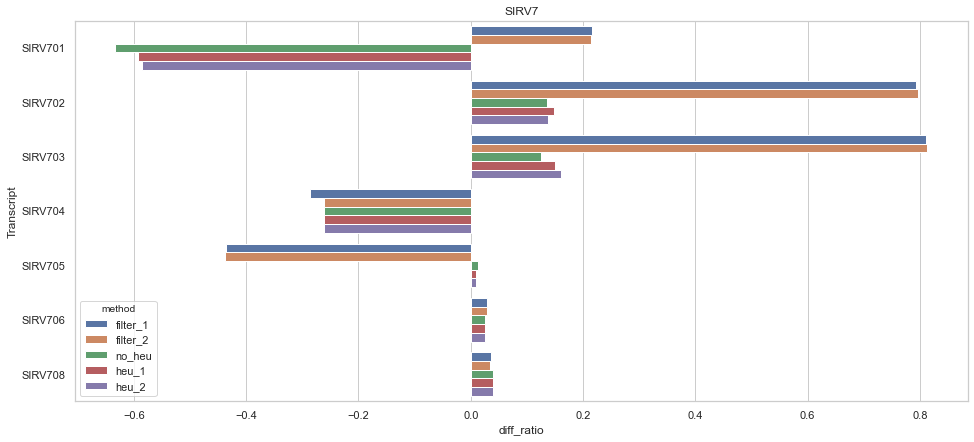

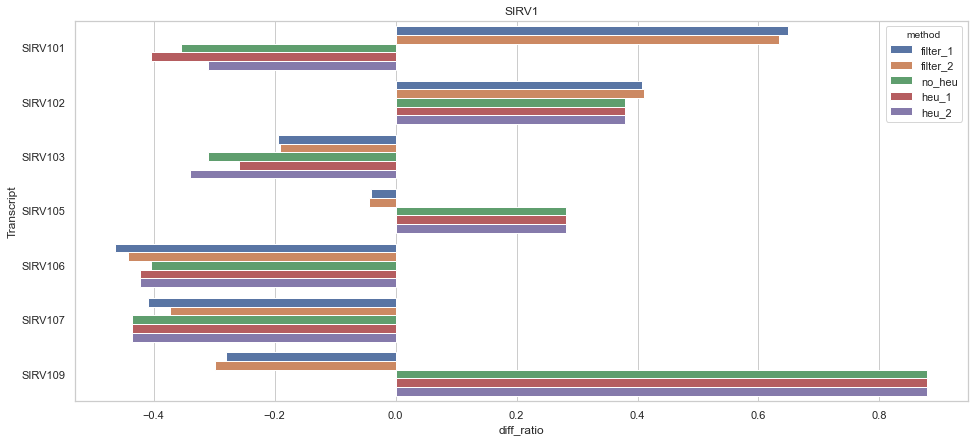

In [26]:
all_bam = {"BYK_GCA_ONT_1_FAK74085_A.bam":["dRNA", "dataset3"],
           "BYK_GCB_ONT_1_FAK69539_A.bam":["cDNA", "dataset3"],
           "BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam":["dRNA", "dataset3_new basecaller"],
           "BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam":["cDNA", "dataset3_new basecaller"],
           "BYK_GDB_ONT_1_PAD67469_A.bam":["dRNA", "dataset4_new_protocols"],
           "BYK_GDC_ONT_1_FAL21661_A.bam":["cDNA", "dataset4_new_protocols"],
           "BYK_GDB_ONT_1_PAD67469_Aflipflop.bam":["dRNA", "dataset4_new_base-caller"],
           "BYK_GDC_ONT_1_FAL21661_Aflipflop.bam":["cDNA", "dataset4_new_base-caller"]}
chrom_list = sorted(list(set([transcript[:5] for transcript in TRANSCRIPT_RATIO.keys()])))
print(chrom_list)
for bam in all_bam.keys():
    print(bam)
    for chrom in chrom_list:
        print(chrom)
        print(bam)
        df = multi_plot_quantif(complete_counts_dict, bam, TRANSCRIPT_RATIO, chrom);
#         df = multi_plot_quantif(countings_dict,bam, TRANSCRIPT_RATIO,chrom )


In [22]:
## Get number and average length of reads

average_length_prior_filter_dict = {}
average_length_post_filter_dict = {}
average_length_post_reattribution_dict = {}
nb_read_prior_filter_dict = {}
nb_read_post_filter_dict = {}
nb_read_post_reattribution_dict = {}
for bam in bam_files.values():
    average_length_prior_filter = 0
    average_length_post_filter = 0
    nb_read_prior_filter = 0
    nb_read_post_filter = 0
    average_length_post_reattribution = 0
    nb_read_post_reattribution = 0
    original_bam = bam
    filtered_bam = bam[:-3] + "filtered_80QC.bam"
    reattributed_bam = bam[:-3] + "filtered.new_primary.no_heuristic.bam"
    aof = pysam.AlignmentFile(PATH_TO_BAM + original_bam)
    aff = pysam.AlignmentFile(PATH_TO_BAM + filtered_bam)
    arf = pysam.AlignmentFile(PATH_TO_BAM + reattributed_bam)

    for ali in pysam.AlignmentFile(PATH_TO_BAM + original_bam):
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            average_length_prior_filter += ali.infer_query_length()
            nb_read_prior_filter += 1
    average_length_prior_filter /= nb_read_prior_filter

    for ali in pysam.AlignmentFile(PATH_TO_BAM + filtered_bam):
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            average_length_post_filter += ali.infer_query_length()
            nb_read_post_filter += 1
    average_length_post_filter /= nb_read_post_filter

    for ali in pysam.AlignmentFile(PATH_TO_BAM + reattributed_bam):
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            average_length_post_reattribution += ali.infer_query_length()
            nb_read_post_reattribution += 1
    average_length_post_reattribution /= nb_read_post_reattribution

    average_length_prior_filter_dict[bam] = average_length_prior_filter
    average_length_post_filter_dict[bam] = average_length_post_filter
    average_length_post_reattribution_dict[bam] = average_length_post_reattribution
    nb_read_prior_filter_dict[bam] = nb_read_prior_filter
    nb_read_post_filter_dict[bam] = nb_read_post_filter
    nb_read_post_reattribution_dict[bam] = nb_read_post_reattribution


In [25]:
print(bam_files.values())
for bam in bam_files.values():
    print(average_length_prior_filter_dict[bam])
print("\n")
for bam in bam_files.values():
    print(average_length_post_filter_dict[bam])
print("\n")
for bam in bam_files.values():
    print(average_length_post_reattribution_dict[bam])
print("\n")
for bam in bam_files.values():
    print(nb_read_prior_filter_dict[bam])
print("\n")
for bam in bam_files.values():
    print(nb_read_post_filter_dict[bam])
print("\n")
for bam in bam_files.values():
    print(nb_read_post_reattribution_dict[bam])

dict_values(['BYK_GCA_ONT_1_FAK74085_A.bam', 'BYK_GCB_ONT_1_FAK69539_A.bam', 'BYK_GCC_ONT_1_FAK82381_A.basecallHA.bam', 'BYK_GCB_ONT_1_FAK69539_A.basecallHA.bam', 'BYK_GDB_ONT_1_PAD67469_A.bam', 'BYK_GDC_ONT_1_FAL21661_A.bam', 'BYK_GDB_ONT_1_PAD67469_Aflipflop.bam', 'BYK_GDC_ONT_1_FAL21661_Aflipflop.bam'])
917.5848803199427
871.7677524117863
901.6759719448186
915.5718051948692
901.662264466047
1043.4256079490979
902.1367205331873
1026.335851350178


919.6350019708317
872.1386875458259
901.9913369234372
920.732430743595
912.7984996817917
867.3352339181287
910.1486954581892
843.2096912521441


919.6099742307109
872.1494196330448
901.9982674658175
920.756310876729
912.8020617922206
867.3696128560994
910.1547470216208
843.3974285714286


33506
198297
21529
202931
832311
11473
832428
11517


32981
190940
21355
192040
812361
6840
815842
6996


32985
191086
21356
192089
812400
6845
815880
7000


In [12]:
bam1 = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered_80QC.bam")
bam2 = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.bam")
bam3 = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.filtered_80QC.keep_secondary.sorted_by_read_names.bam")
bam4 = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.new_primary.no_heuristic.bam")

bam1_names = []
bam2_names = []
bam3_names = []
bam4_names = []

diff = []
for ali in bam1:
    bam1_names.append(ali.query_name)
bam1_names = list(set(bam1_names))
for ali in bam2:
    bam2_names.append(ali.query_name)
bam2_names = list(set(bam2_names))
for read in bam1_names:
    if read not in bam2_names:
        diff.append(read)
print(diff)

[]


In [11]:
# Diff contient les reads qui sont dans bam1 mais pas dans bam2

bam2 = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.bam")
bam3 = pysam.AlignmentFile(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.filtered_80QC.keep_secondary.sorted_by_read_names.bam")

for ali in bam2:
    if ali.query_name in diff:
        print(ali.query_name)

In [102]:
def filtering_80QC_unmapped_and_supplementary(bamfile) :
    inputFile = pysam.AlignmentFile(bamfile, "rb")
    outputFile = bamfile[:-3] + "filtered.bam"
    filtered_bam = pysam.AlignmentFile(outputFile, "wb", template = inputFile)
    for ali in inputFile:
        if ali.is_supplementary or ali.is_unmapped:
            pass
        else :
            if has_QC_greater_than_80(ali):
                filtered_bam.write(ali)
    return outputFile
                
def sort_by_read_name(bamfile):
    outputFile = bamfile[:-3] + "filtered_80QC.keep_secondary.sorted_by_read_names.bam"
    pysam.sort("-n", bamfile, "-o", outputFile)
    return outputFile            

def filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(bamfile) -> str:
    temp_file = filtering_80QC_unmapped_and_supplementary(bamfile)    
    return sort_by_read_name(temp_file)
    

In [101]:
filtering_80QC_unmapped_and_supplementary_and_sorting_by_read_names(PATH_TO_BAM + "BYK_GDC_ONT_1_FAL21661_Aflipflop.bam")

'/home/ericcumunel/Documents/Aster/bam/spike_in/BYK_GDC_ONT_1_FAL21661_Aflipflop.filtered.filtered_80QC.keep_secondary.sorted_by_read_names.bam'

## NanoCount command generator

In [54]:
reads = ["BYK_GCA_ONT_1_FAK74085_A.fastq.gz", "BYK_GDC_ONT_1_FAL21661_Aflipflop.fastq.gz", "BYK_GCB_ONT_1_FAK69539_A.basecallHA.fastq.gz  BYK_GDD_ONT_1_FAL09183_A.fastq.gz","BYK_GCB_ONT_1_FAK69539_A.fastq.gz", "BYK_GDD_ONT_1_FAL09183_Aflipflop.fastq.gz", "BYK_GCC_ONT_1_FAK82381_A.basecallHA.fastq.gz  BYK_GDE_ONT_1_FAL24627_A.fastq.gz","BYK_GDA_ONT_1_PAD67578_A.fastq.gz","BYK_GDE_ONT_1_FAL24627_Aflipflop.fastq.gz","BYK_GDB_ONT_1_PAD67469_A.fastq.gz","BYK_GE_ONT_1_FAL24604_A.fastq.gz","BYK_GDB_ONT_1_PAD67469_Aflipflop.fastq.gz","BYK_GE_ONT_1_FAL24604_Aflipflop.fastq.gz","BYK_GDC_ONT_1_FAL21661_A.fastq.gz"]
transcriptome = "/data/home/ecumunel/Aster/fasta/SIRV_transcriptome.fa" 
PATH_TO_FASTA = "/newdisk/ecumunel/Aster/raw_data/reads/"
PATH_TO_NANO_BAM = "/newdisk/ecumunel/Aster/bam/nanocount_bam/"
PATH_TO_NANO_OUTPUT = "/newdisk/ecumunel/Aster/nanocount_output/"
for read in reads :
    command = "minimap2 -t 12 -ax map-ont -p 0 -N 10 " + transcriptome + " " + PATH_TO_FASTA + read + "| samtools view -bh >"
    bamfile = PATH_TO_NANO_BAM + read.split(".")[0] + ".bam"
    counts_file = PATH_TO_NANO_OUTPUT + read.split(".")[0] + ".tsv"
    command += bamfile + ";\n"
    command += "NanoCount -i " + bamfile + " -o " + counts_file + ";\n"
    print(command)
# transcriptome.fa.gz reads.fastq.gz | samtools view -bh > aligned_reads.bam"

minimap2 -t 12 -ax map-ont -p 0 -N 10 /data/home/ecumunel/Aster/fasta/SIRV_transcriptome.fa /newdisk/ecumunel/Aster/raw_data/reads/BYK_GCA_ONT_1_FAK74085_A.fastq.gz| samtools view -bh >/newdisk/ecumunel/Aster/bam/nanocount_bam/BYK_GCA_ONT_1_FAK74085_A.bam;
NanoCount -i /newdisk/ecumunel/Aster/bam/nanocount_bam/BYK_GCA_ONT_1_FAK74085_A.bam -o /newdisk/ecumunel/Aster/nanocount_output/BYK_GCA_ONT_1_FAK74085_A.tsv;

minimap2 -t 12 -ax map-ont -p 0 -N 10 /data/home/ecumunel/Aster/fasta/SIRV_transcriptome.fa /newdisk/ecumunel/Aster/raw_data/reads/BYK_GDC_ONT_1_FAL21661_Aflipflop.fastq.gz| samtools view -bh >/newdisk/ecumunel/Aster/bam/nanocount_bam/BYK_GDC_ONT_1_FAL21661_Aflipflop.bam;
NanoCount -i /newdisk/ecumunel/Aster/bam/nanocount_bam/BYK_GDC_ONT_1_FAL21661_Aflipflop.bam -o /newdisk/ecumunel/Aster/nanocount_output/BYK_GDC_ONT_1_FAL21661_Aflipflop.tsv;

minimap2 -t 12 -ax map-ont -p 0 -N 10 /data/home/ecumunel/Aster/fasta/SIRV_transcriptome.fa /newdisk/ecumunel/Aster/raw_data/reads/BYK_G

## Quantification using NanoCount

In [56]:
def get_correlation_from_nanocount(countings_nanocount_file):
    raw_countings = {}
    real_quantif = []
    with open(countings_nanocount_file, 'r') as f:
        next(f)
        for line in f:
            line = line.split()
            raw_countings[line[0]] = line[2]
    sorted_countings = []
    for transcript, count in TRANSCRIPT_RATIO.items():
#         print(raw_countings[transcript], count)
        sorted_countings.append(float(raw_countings[transcript]))
        real_quantif.append(float(count))
    return spearmanr(sorted_countings, real_quantif)



In [64]:
get_correlation_from_nanocount(PATH_TO_BAM + "nanocount_output/BYK_GDE_ONT_1_FAL24627_Aflipflop.tsv")

SpearmanrResult(correlation=0.7206099758901259, pvalue=6.1920393976035435e-12)